# Problem Statement

To build a prediction model that will accurately classify which texts are spam

### 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [3]:
import Text_Data_Preprocessing
import Spam_Utils

import joblib,pickle

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score,classification_report,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve

### 2. Data set Loading

#### Dataset path:
<a href =https://www.kaggle.com/uciml/sms-spam-collection-dataset>SMS Spam collection Dataset</a>

In [5]:
##pd.read_csv('Data/spam.csv')
#pd.read_csv('Data/spam.csv',encoding='latin-1')

it is giving encoding error so first we will check that what is the encoding format of this dataset

In [6]:
import chardet

In [7]:
with open('Data/spam.csv','rb') as rawdata:
    result= chardet.detect(rawdata.read(100000))
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}


In [8]:
smsdata = pd.read_csv('Data/spam.csv',encoding='Windows-1252')

smsdata.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
smsdata = smsdata.iloc[:,:2]
smsdata.columns = ['Target','SMS']

smsdata.head(3)

,Target,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [10]:
smsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### 3. EDA

##### Target Class Distribution

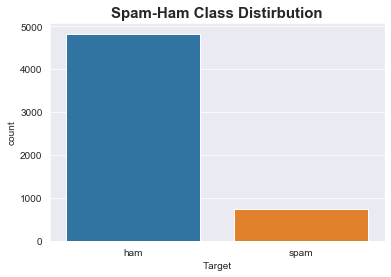

In [11]:
plt.figure(figsize=(6,4))
plt.title('Spam-Ham Class Distirbution',fontsize=15,fontweight='bold')
sns.countplot(smsdata['Target']);

In [12]:
smsdata1 = smsdata.copy()

In [13]:
smsdata1['No_of_char'] = smsdata1['SMS'].apply(len)

In [14]:
#smsdata1.apply(lambda df:word_tokenize(df['SMS']),axis=1).apply(len)

smsdata1['No_of_words'] = smsdata1.apply(lambda df:len(word_tokenize(df['SMS'])),axis=1)

In [15]:
#smsdata1.apply(lambda df:sent_tokenize(df['SMS']),axis=1).apply(len)
smsdata1['No_of_sent'] = smsdata1.apply(lambda df: len(sent_tokenize(df['SMS'])),axis=1)

In [16]:
smsdata1.head()

,Target,SMS,No_of_char,No_of_words,No_of_sent
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
smsdata1.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_char,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_words,5572.0,18.501974,13.637741,1.0,9.0,15.0,27.0,219.0
No_of_sent,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


<Figure size 576x432 with 0 Axes>

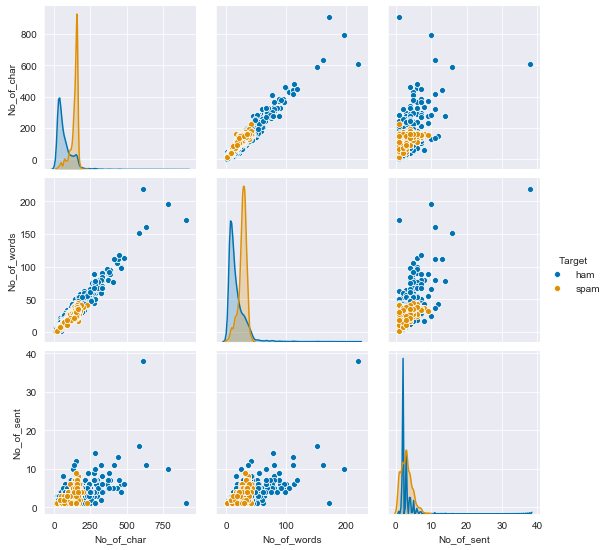

In [18]:
plt.figure(figsize=(8,6))
sns.pairplot(smsdata1,hue='Target',palette='colorblind');
plt.show();

We can see from above plot **ham** class has some outliers. So we will drop the records having no_of_char having greater than (mean + 3 * std dev)

In [19]:
smsdata1 = smsdata1[smsdata1['No_of_char']<260] ## mean=80 , std = 60 so 80+ (3*60)=260

In [20]:
((smsdata.shape[0] - smsdata1.shape[0])/smsdata.shape[0]) *100

1.148600143575018

Around 1.14% records are outliers so we have dropped them and will proceed with 5508 records for further processing

<Figure size 576x432 with 0 Axes>

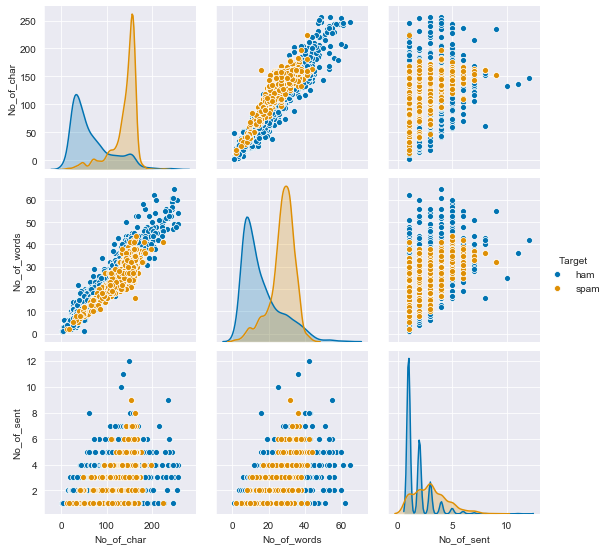

In [21]:
plt.figure(figsize=(8,6))
sns.pairplot(smsdata1,hue='Target',palette='colorblind');
plt.show();

### 4. Data Preprocessing

In [22]:
smsdata1.index =range(len(smsdata1))
print(smsdata1.index)

RangeIndex(start=0, stop=5508, step=1)


In [23]:
%%time
SMS_list = Text_Data_Preprocessing.data_preprocessing(smsdata1,'SMS')

Wall time: 1min 32s


In [24]:
%%time
X = Text_Data_Preprocessing.BOW(SMS_list)

Wall time: 325 ms


In [25]:
pd.DataFrame(X).head(4)

,0,1,2,3,4,5,6,7,8,9,...,6757,6758,6759,6760,6761,6762,6763,6764,6765,6766
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
smsdata1['Target'].value_counts()

ham     4761
spam     747
Name: Target, dtype: int64

In [27]:
Y = smsdata1['Target'].map({'ham':0,'spam':1})

### 5. Model Building

In [28]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=101,shuffle=True)

print("Train Dataset Size: ",len(x_train))
print("Test Dataset Size: ",len(x_test))

Train Dataset Size:  4131
Test Dataset Size:  1377


In [29]:
Model_logging = pd.DataFrame(columns=['Model','Train_Score','Test_Score','F1_Score','Precision_at_Recall'])

Model_logging

,Model,Train_Score,Test_Score,F1_Score,Precision_at_Recall


In [30]:
### init various models 

spam_svc = SVC(random_state=101)

spam_knn = KNeighborsClassifier()

spam_nb = MultinomialNB()

spam_rf = RandomForestClassifier(random_state=101)

spam_xgboost = XGBRFClassifier(random_state=101)

spam_catboost = CatBoostClassifier(random_state=101)

spam_lgbm = LGBMClassifier(random_state=101)

In [31]:
Models = {'KNN': spam_knn,
         'NaiveBayes': spam_nb,
         'RandomForest':spam_rf,
         'XGB':spam_xgboost,
         'CatBoost':spam_catboost,
         'LGBM':spam_lgbm}

In [32]:
y_train_preds = []
y_test_preds = []
estimator_list = []

model_data_path = 'Models/'

In [33]:
%%time 

for algo,model in Models.items():
    estimator,y_train_pred,y_test_pred,Model_logging = Spam_Utils.model_building(model,x_train,y_train,x_test,y_test,algo,Model_logging)
    
    y_train_preds.append(y_train_pred)
    y_test_preds.append(y_test_pred)
    estimator_list.append(estimator)
    
    pickle.dump(estimator, open(model_data_path + algo + '.pkl','wb'))

Learning rate set to 0.018879
0:	learn: 0.6698718	total: 216ms	remaining: 3m 35s
1:	learn: 0.6474694	total: 245ms	remaining: 2m 2s
2:	learn: 0.6260471	total: 274ms	remaining: 1m 30s
3:	learn: 0.6072863	total: 300ms	remaining: 1m 14s
4:	learn: 0.5876747	total: 327ms	remaining: 1m 4s
5:	learn: 0.5707092	total: 354ms	remaining: 58.6s
6:	learn: 0.5554579	total: 379ms	remaining: 53.7s
7:	learn: 0.5372608	total: 409ms	remaining: 50.7s
8:	learn: 0.5215790	total: 442ms	remaining: 48.7s
9:	learn: 0.5077237	total: 474ms	remaining: 46.9s
10:	learn: 0.4948604	total: 508ms	remaining: 45.7s
11:	learn: 0.4807912	total: 539ms	remaining: 44.4s
12:	learn: 0.4675357	total: 566ms	remaining: 43s
13:	learn: 0.4551441	total: 591ms	remaining: 41.6s
14:	learn: 0.4437792	total: 619ms	remaining: 40.6s
15:	learn: 0.4328626	total: 650ms	remaining: 40s
16:	learn: 0.4245650	total: 675ms	remaining: 39.1s
17:	learn: 0.4166255	total: 702ms	remaining: 38.3s
18:	learn: 0.4048033	total: 728ms	remaining: 37.6s
19:	learn: 0

160:	learn: 0.1205253	total: 5.28s	remaining: 27.5s
161:	learn: 0.1201322	total: 5.3s	remaining: 27.4s
162:	learn: 0.1196002	total: 5.34s	remaining: 27.4s
163:	learn: 0.1192374	total: 5.39s	remaining: 27.5s
164:	learn: 0.1188256	total: 5.42s	remaining: 27.4s
165:	learn: 0.1184693	total: 5.45s	remaining: 27.4s
166:	learn: 0.1180516	total: 5.49s	remaining: 27.4s
167:	learn: 0.1177531	total: 5.52s	remaining: 27.3s
168:	learn: 0.1174242	total: 5.55s	remaining: 27.3s
169:	learn: 0.1170951	total: 5.58s	remaining: 27.3s
170:	learn: 0.1167280	total: 5.61s	remaining: 27.2s
171:	learn: 0.1164180	total: 5.64s	remaining: 27.2s
172:	learn: 0.1160204	total: 5.68s	remaining: 27.2s
173:	learn: 0.1156672	total: 5.71s	remaining: 27.1s
174:	learn: 0.1153153	total: 5.74s	remaining: 27.1s
175:	learn: 0.1149962	total: 5.77s	remaining: 27s
176:	learn: 0.1147222	total: 5.8s	remaining: 27s
177:	learn: 0.1143710	total: 5.83s	remaining: 26.9s
178:	learn: 0.1141101	total: 5.87s	remaining: 26.9s
179:	learn: 0.1137

321:	learn: 0.0904458	total: 9.86s	remaining: 20.8s
322:	learn: 0.0903474	total: 9.89s	remaining: 20.7s
323:	learn: 0.0902997	total: 9.92s	remaining: 20.7s
324:	learn: 0.0902538	total: 9.96s	remaining: 20.7s
325:	learn: 0.0900376	total: 9.99s	remaining: 20.7s
326:	learn: 0.0898481	total: 10s	remaining: 20.6s
327:	learn: 0.0897964	total: 10.1s	remaining: 20.6s
328:	learn: 0.0896474	total: 10.1s	remaining: 20.6s
329:	learn: 0.0894461	total: 10.1s	remaining: 20.6s
330:	learn: 0.0892227	total: 10.2s	remaining: 20.5s
331:	learn: 0.0891678	total: 10.2s	remaining: 20.5s
332:	learn: 0.0891215	total: 10.2s	remaining: 20.5s
333:	learn: 0.0890455	total: 10.3s	remaining: 20.5s
334:	learn: 0.0889916	total: 10.3s	remaining: 20.4s
335:	learn: 0.0889524	total: 10.3s	remaining: 20.4s
336:	learn: 0.0889087	total: 10.4s	remaining: 20.4s
337:	learn: 0.0888406	total: 10.4s	remaining: 20.4s
338:	learn: 0.0887987	total: 10.4s	remaining: 20.3s
339:	learn: 0.0887543	total: 10.4s	remaining: 20.3s
340:	learn: 0.

484:	learn: 0.0772476	total: 14.9s	remaining: 15.8s
485:	learn: 0.0772089	total: 14.9s	remaining: 15.7s
486:	learn: 0.0771670	total: 14.9s	remaining: 15.7s
487:	learn: 0.0771281	total: 14.9s	remaining: 15.7s
488:	learn: 0.0770915	total: 15s	remaining: 15.6s
489:	learn: 0.0770532	total: 15s	remaining: 15.6s
490:	learn: 0.0769835	total: 15s	remaining: 15.6s
491:	learn: 0.0769194	total: 15.1s	remaining: 15.5s
492:	learn: 0.0767129	total: 15.1s	remaining: 15.5s
493:	learn: 0.0765232	total: 15.1s	remaining: 15.5s
494:	learn: 0.0764592	total: 15.1s	remaining: 15.4s
495:	learn: 0.0764150	total: 15.2s	remaining: 15.4s
496:	learn: 0.0763779	total: 15.2s	remaining: 15.4s
497:	learn: 0.0761470	total: 15.2s	remaining: 15.3s
498:	learn: 0.0761093	total: 15.2s	remaining: 15.3s
499:	learn: 0.0760598	total: 15.3s	remaining: 15.3s
500:	learn: 0.0759999	total: 15.3s	remaining: 15.2s
501:	learn: 0.0759624	total: 15.3s	remaining: 15.2s
502:	learn: 0.0757652	total: 15.3s	remaining: 15.2s
503:	learn: 0.0757

644:	learn: 0.0660224	total: 19.3s	remaining: 10.6s
645:	learn: 0.0659243	total: 19.3s	remaining: 10.6s
646:	learn: 0.0658981	total: 19.3s	remaining: 10.5s
647:	learn: 0.0658481	total: 19.3s	remaining: 10.5s
648:	learn: 0.0657585	total: 19.4s	remaining: 10.5s
649:	learn: 0.0655803	total: 19.4s	remaining: 10.4s
650:	learn: 0.0654572	total: 19.4s	remaining: 10.4s
651:	learn: 0.0654304	total: 19.4s	remaining: 10.4s
652:	learn: 0.0654039	total: 19.5s	remaining: 10.3s
653:	learn: 0.0653114	total: 19.5s	remaining: 10.3s
654:	learn: 0.0652846	total: 19.5s	remaining: 10.3s
655:	learn: 0.0651082	total: 19.5s	remaining: 10.2s
656:	learn: 0.0650204	total: 19.6s	remaining: 10.2s
657:	learn: 0.0649938	total: 19.6s	remaining: 10.2s
658:	learn: 0.0649675	total: 19.6s	remaining: 10.2s
659:	learn: 0.0648943	total: 19.7s	remaining: 10.1s
660:	learn: 0.0647390	total: 19.7s	remaining: 10.1s
661:	learn: 0.0646079	total: 19.7s	remaining: 10.1s
662:	learn: 0.0645818	total: 19.8s	remaining: 10s
663:	learn: 0.

803:	learn: 0.0566931	total: 23.6s	remaining: 5.75s
804:	learn: 0.0566672	total: 23.6s	remaining: 5.72s
805:	learn: 0.0566468	total: 23.6s	remaining: 5.69s
806:	learn: 0.0566213	total: 23.7s	remaining: 5.66s
807:	learn: 0.0565653	total: 23.7s	remaining: 5.63s
808:	learn: 0.0564628	total: 23.7s	remaining: 5.6s
809:	learn: 0.0563937	total: 23.8s	remaining: 5.57s
810:	learn: 0.0563327	total: 23.8s	remaining: 5.54s
811:	learn: 0.0562914	total: 23.8s	remaining: 5.51s
812:	learn: 0.0562712	total: 23.9s	remaining: 5.49s
813:	learn: 0.0561493	total: 23.9s	remaining: 5.46s
814:	learn: 0.0560474	total: 23.9s	remaining: 5.43s
815:	learn: 0.0560273	total: 23.9s	remaining: 5.4s
816:	learn: 0.0560057	total: 24s	remaining: 5.37s
817:	learn: 0.0559662	total: 24s	remaining: 5.34s
818:	learn: 0.0559462	total: 24s	remaining: 5.31s
819:	learn: 0.0558694	total: 24.1s	remaining: 5.28s
820:	learn: 0.0558480	total: 24.1s	remaining: 5.25s
821:	learn: 0.0557289	total: 24.1s	remaining: 5.22s
822:	learn: 0.055709

962:	learn: 0.0492388	total: 27.7s	remaining: 1.06s
963:	learn: 0.0491424	total: 27.7s	remaining: 1.04s
964:	learn: 0.0491264	total: 27.8s	remaining: 1.01s
965:	learn: 0.0491107	total: 27.8s	remaining: 978ms
966:	learn: 0.0490433	total: 27.8s	remaining: 949ms
967:	learn: 0.0490274	total: 27.8s	remaining: 920ms
968:	learn: 0.0490117	total: 27.9s	remaining: 892ms
969:	learn: 0.0489127	total: 27.9s	remaining: 863ms
970:	learn: 0.0488567	total: 27.9s	remaining: 834ms
971:	learn: 0.0488410	total: 27.9s	remaining: 805ms
972:	learn: 0.0488005	total: 28s	remaining: 776ms
973:	learn: 0.0487848	total: 28s	remaining: 747ms
974:	learn: 0.0487692	total: 28s	remaining: 718ms
975:	learn: 0.0486955	total: 28s	remaining: 690ms
976:	learn: 0.0486656	total: 28.1s	remaining: 661ms
977:	learn: 0.0486082	total: 28.1s	remaining: 632ms
978:	learn: 0.0485926	total: 28.1s	remaining: 603ms
979:	learn: 0.0485059	total: 28.1s	remaining: 574ms
980:	learn: 0.0484903	total: 28.2s	remaining: 545ms
981:	learn: 0.048420

124:	learn: 0.1495328	total: 2.78s	remaining: 19.5s
125:	learn: 0.1488101	total: 2.8s	remaining: 19.5s
126:	learn: 0.1482556	total: 2.83s	remaining: 19.4s
127:	learn: 0.1476362	total: 2.85s	remaining: 19.4s
128:	learn: 0.1470751	total: 2.87s	remaining: 19.4s
129:	learn: 0.1466373	total: 2.89s	remaining: 19.3s
130:	learn: 0.1460080	total: 2.91s	remaining: 19.3s
131:	learn: 0.1453667	total: 2.93s	remaining: 19.3s
132:	learn: 0.1447129	total: 2.96s	remaining: 19.3s
133:	learn: 0.1438661	total: 2.98s	remaining: 19.2s
134:	learn: 0.1432930	total: 3s	remaining: 19.2s
135:	learn: 0.1427708	total: 3.02s	remaining: 19.2s
136:	learn: 0.1423707	total: 3.04s	remaining: 19.2s
137:	learn: 0.1418611	total: 3.06s	remaining: 19.1s
138:	learn: 0.1413655	total: 3.09s	remaining: 19.1s
139:	learn: 0.1409107	total: 3.11s	remaining: 19.1s
140:	learn: 0.1404816	total: 3.13s	remaining: 19.1s
141:	learn: 0.1398904	total: 3.15s	remaining: 19s
142:	learn: 0.1393853	total: 3.17s	remaining: 19s
143:	learn: 0.138814

288:	learn: 0.1007625	total: 6.51s	remaining: 16s
289:	learn: 0.1005967	total: 6.53s	remaining: 16s
290:	learn: 0.1005182	total: 6.56s	remaining: 16s
291:	learn: 0.1004497	total: 6.58s	remaining: 15.9s
292:	learn: 0.1003773	total: 6.6s	remaining: 15.9s
293:	learn: 0.1002965	total: 6.62s	remaining: 15.9s
294:	learn: 0.1002274	total: 6.64s	remaining: 15.9s
295:	learn: 0.1001515	total: 6.67s	remaining: 15.9s
296:	learn: 0.1000331	total: 6.69s	remaining: 15.8s
297:	learn: 0.0999762	total: 6.71s	remaining: 15.8s
298:	learn: 0.0999286	total: 6.73s	remaining: 15.8s
299:	learn: 0.0998739	total: 6.76s	remaining: 15.8s
300:	learn: 0.0996932	total: 6.78s	remaining: 15.7s
301:	learn: 0.0996414	total: 6.8s	remaining: 15.7s
302:	learn: 0.0995302	total: 6.83s	remaining: 15.7s
303:	learn: 0.0993725	total: 6.85s	remaining: 15.7s
304:	learn: 0.0991839	total: 6.88s	remaining: 15.7s
305:	learn: 0.0991235	total: 6.9s	remaining: 15.7s
306:	learn: 0.0988803	total: 6.93s	remaining: 15.6s
307:	learn: 0.0988250

449:	learn: 0.0860852	total: 10.3s	remaining: 12.6s
450:	learn: 0.0860174	total: 10.3s	remaining: 12.5s
451:	learn: 0.0859763	total: 10.3s	remaining: 12.5s
452:	learn: 0.0859287	total: 10.3s	remaining: 12.5s
453:	learn: 0.0856705	total: 10.4s	remaining: 12.5s
454:	learn: 0.0856296	total: 10.4s	remaining: 12.5s
455:	learn: 0.0855851	total: 10.4s	remaining: 12.4s
456:	learn: 0.0855279	total: 10.5s	remaining: 12.4s
457:	learn: 0.0854881	total: 10.5s	remaining: 12.4s
458:	learn: 0.0854322	total: 10.5s	remaining: 12.4s
459:	learn: 0.0852167	total: 10.5s	remaining: 12.4s
460:	learn: 0.0851739	total: 10.6s	remaining: 12.3s
461:	learn: 0.0850563	total: 10.6s	remaining: 12.3s
462:	learn: 0.0849885	total: 10.6s	remaining: 12.3s
463:	learn: 0.0847701	total: 10.6s	remaining: 12.3s
464:	learn: 0.0847223	total: 10.7s	remaining: 12.3s
465:	learn: 0.0846751	total: 10.7s	remaining: 12.3s
466:	learn: 0.0846277	total: 10.8s	remaining: 12.3s
467:	learn: 0.0844579	total: 10.8s	remaining: 12.2s
468:	learn: 

616:	learn: 0.0733623	total: 14.8s	remaining: 9.16s
617:	learn: 0.0733232	total: 14.8s	remaining: 9.14s
618:	learn: 0.0732650	total: 14.8s	remaining: 9.11s
619:	learn: 0.0732114	total: 14.8s	remaining: 9.09s
620:	learn: 0.0731554	total: 14.8s	remaining: 9.06s
621:	learn: 0.0731060	total: 14.9s	remaining: 9.04s
622:	learn: 0.0730674	total: 14.9s	remaining: 9.01s
623:	learn: 0.0730138	total: 14.9s	remaining: 8.98s
624:	learn: 0.0729772	total: 14.9s	remaining: 8.96s
625:	learn: 0.0729130	total: 15s	remaining: 8.93s
626:	learn: 0.0727960	total: 15s	remaining: 8.91s
627:	learn: 0.0727655	total: 15s	remaining: 8.88s
628:	learn: 0.0725747	total: 15s	remaining: 8.86s
629:	learn: 0.0725298	total: 15s	remaining: 8.84s
630:	learn: 0.0724745	total: 15.1s	remaining: 8.81s
631:	learn: 0.0724425	total: 15.1s	remaining: 8.79s
632:	learn: 0.0724033	total: 15.1s	remaining: 8.76s
633:	learn: 0.0722705	total: 15.1s	remaining: 8.74s
634:	learn: 0.0722314	total: 15.2s	remaining: 8.72s
635:	learn: 0.0720620	

777:	learn: 0.0630111	total: 18.6s	remaining: 5.32s
778:	learn: 0.0629151	total: 18.7s	remaining: 5.29s
779:	learn: 0.0628878	total: 18.7s	remaining: 5.27s
780:	learn: 0.0628628	total: 18.7s	remaining: 5.24s
781:	learn: 0.0628222	total: 18.7s	remaining: 5.22s
782:	learn: 0.0627974	total: 18.7s	remaining: 5.2s
783:	learn: 0.0627186	total: 18.8s	remaining: 5.17s
784:	learn: 0.0625693	total: 18.8s	remaining: 5.15s
785:	learn: 0.0624209	total: 18.8s	remaining: 5.12s
786:	learn: 0.0623961	total: 18.8s	remaining: 5.1s
787:	learn: 0.0623711	total: 18.9s	remaining: 5.07s
788:	learn: 0.0623301	total: 18.9s	remaining: 5.05s
789:	learn: 0.0623053	total: 18.9s	remaining: 5.02s
790:	learn: 0.0621913	total: 18.9s	remaining: 5s
791:	learn: 0.0621669	total: 18.9s	remaining: 4.97s
792:	learn: 0.0620039	total: 19s	remaining: 4.95s
793:	learn: 0.0619793	total: 19s	remaining: 4.93s
794:	learn: 0.0618286	total: 19s	remaining: 4.9s
795:	learn: 0.0617139	total: 19s	remaining: 4.88s
796:	learn: 0.0616853	tota

938:	learn: 0.0545559	total: 22.5s	remaining: 1.46s
939:	learn: 0.0544533	total: 22.5s	remaining: 1.44s
940:	learn: 0.0544341	total: 22.5s	remaining: 1.41s
941:	learn: 0.0544137	total: 22.6s	remaining: 1.39s
942:	learn: 0.0543934	total: 22.6s	remaining: 1.36s
943:	learn: 0.0543744	total: 22.6s	remaining: 1.34s
944:	learn: 0.0543426	total: 22.6s	remaining: 1.32s
945:	learn: 0.0543239	total: 22.7s	remaining: 1.29s
946:	learn: 0.0543038	total: 22.7s	remaining: 1.27s
947:	learn: 0.0542850	total: 22.7s	remaining: 1.25s
948:	learn: 0.0542651	total: 22.7s	remaining: 1.22s
949:	learn: 0.0541661	total: 22.8s	remaining: 1.2s
950:	learn: 0.0541473	total: 22.8s	remaining: 1.17s
951:	learn: 0.0540566	total: 22.8s	remaining: 1.15s
952:	learn: 0.0540385	total: 22.8s	remaining: 1.13s
953:	learn: 0.0540188	total: 22.8s	remaining: 1.1s
954:	learn: 0.0539990	total: 22.9s	remaining: 1.08s
955:	learn: 0.0539683	total: 22.9s	remaining: 1.05s
956:	learn: 0.0538413	total: 22.9s	remaining: 1.03s
957:	learn: 0.

103:	learn: 0.1603687	total: 2.39s	remaining: 20.6s
104:	learn: 0.1596347	total: 2.41s	remaining: 20.6s
105:	learn: 0.1586535	total: 2.44s	remaining: 20.5s
106:	learn: 0.1578737	total: 2.46s	remaining: 20.5s
107:	learn: 0.1570345	total: 2.48s	remaining: 20.5s
108:	learn: 0.1563009	total: 2.5s	remaining: 20.5s
109:	learn: 0.1553441	total: 2.53s	remaining: 20.4s
110:	learn: 0.1544885	total: 2.55s	remaining: 20.4s
111:	learn: 0.1536548	total: 2.57s	remaining: 20.4s
112:	learn: 0.1527646	total: 2.6s	remaining: 20.4s
113:	learn: 0.1521282	total: 2.62s	remaining: 20.3s
114:	learn: 0.1513795	total: 2.64s	remaining: 20.3s
115:	learn: 0.1506286	total: 2.66s	remaining: 20.3s
116:	learn: 0.1498552	total: 2.69s	remaining: 20.3s
117:	learn: 0.1489867	total: 2.71s	remaining: 20.3s
118:	learn: 0.1482183	total: 2.73s	remaining: 20.2s
119:	learn: 0.1474586	total: 2.76s	remaining: 20.2s
120:	learn: 0.1465514	total: 2.78s	remaining: 20.2s
121:	learn: 0.1460144	total: 2.8s	remaining: 20.2s
122:	learn: 0.1

269:	learn: 0.0949693	total: 6.18s	remaining: 16.7s
270:	learn: 0.0947773	total: 6.2s	remaining: 16.7s
271:	learn: 0.0947044	total: 6.23s	remaining: 16.7s
272:	learn: 0.0946314	total: 6.25s	remaining: 16.6s
273:	learn: 0.0945637	total: 6.27s	remaining: 16.6s
274:	learn: 0.0942973	total: 6.29s	remaining: 16.6s
275:	learn: 0.0942312	total: 6.32s	remaining: 16.6s
276:	learn: 0.0941574	total: 6.34s	remaining: 16.5s
277:	learn: 0.0940929	total: 6.36s	remaining: 16.5s
278:	learn: 0.0940348	total: 6.38s	remaining: 16.5s
279:	learn: 0.0939560	total: 6.41s	remaining: 16.5s
280:	learn: 0.0938944	total: 6.43s	remaining: 16.5s
281:	learn: 0.0938269	total: 6.45s	remaining: 16.4s
282:	learn: 0.0937589	total: 6.47s	remaining: 16.4s
283:	learn: 0.0936998	total: 6.5s	remaining: 16.4s
284:	learn: 0.0934847	total: 6.52s	remaining: 16.4s
285:	learn: 0.0934231	total: 6.54s	remaining: 16.3s
286:	learn: 0.0933626	total: 6.57s	remaining: 16.3s
287:	learn: 0.0931479	total: 6.59s	remaining: 16.3s
288:	learn: 0.

434:	learn: 0.0804120	total: 10s	remaining: 13s
435:	learn: 0.0803669	total: 10s	remaining: 13s
436:	learn: 0.0803223	total: 10s	remaining: 12.9s
437:	learn: 0.0802765	total: 10.1s	remaining: 12.9s
438:	learn: 0.0800831	total: 10.1s	remaining: 12.9s
439:	learn: 0.0798219	total: 10.1s	remaining: 12.9s
440:	learn: 0.0797759	total: 10.1s	remaining: 12.8s
441:	learn: 0.0797179	total: 10.2s	remaining: 12.8s
442:	learn: 0.0795225	total: 10.2s	remaining: 12.8s
443:	learn: 0.0792991	total: 10.2s	remaining: 12.8s
444:	learn: 0.0792523	total: 10.2s	remaining: 12.8s
445:	learn: 0.0792036	total: 10.2s	remaining: 12.7s
446:	learn: 0.0791642	total: 10.3s	remaining: 12.7s
447:	learn: 0.0789418	total: 10.3s	remaining: 12.7s
448:	learn: 0.0787861	total: 10.3s	remaining: 12.7s
449:	learn: 0.0785627	total: 10.3s	remaining: 12.6s
450:	learn: 0.0784058	total: 10.4s	remaining: 12.6s
451:	learn: 0.0783605	total: 10.4s	remaining: 12.6s
452:	learn: 0.0783008	total: 10.4s	remaining: 12.6s
453:	learn: 0.0782568	

601:	learn: 0.0669065	total: 13.8s	remaining: 9.12s
602:	learn: 0.0668696	total: 13.8s	remaining: 9.1s
603:	learn: 0.0668101	total: 13.8s	remaining: 9.08s
604:	learn: 0.0667135	total: 13.9s	remaining: 9.06s
605:	learn: 0.0666834	total: 13.9s	remaining: 9.03s
606:	learn: 0.0666540	total: 13.9s	remaining: 9.01s
607:	learn: 0.0666104	total: 13.9s	remaining: 8.99s
608:	learn: 0.0665047	total: 14s	remaining: 8.96s
609:	learn: 0.0664746	total: 14s	remaining: 8.94s
610:	learn: 0.0664454	total: 14s	remaining: 8.92s
611:	learn: 0.0662719	total: 14s	remaining: 8.9s
612:	learn: 0.0662334	total: 14.1s	remaining: 8.88s
613:	learn: 0.0662046	total: 14.1s	remaining: 8.85s
614:	learn: 0.0660961	total: 14.1s	remaining: 8.83s
615:	learn: 0.0659456	total: 14.1s	remaining: 8.81s
616:	learn: 0.0658065	total: 14.2s	remaining: 8.78s
617:	learn: 0.0657231	total: 14.2s	remaining: 8.76s
618:	learn: 0.0656499	total: 14.2s	remaining: 8.74s
619:	learn: 0.0656203	total: 14.2s	remaining: 8.72s
620:	learn: 0.0654395	

765:	learn: 0.0559883	total: 17.6s	remaining: 5.37s
766:	learn: 0.0558422	total: 17.6s	remaining: 5.35s
767:	learn: 0.0558204	total: 17.6s	remaining: 5.32s
768:	learn: 0.0557987	total: 17.6s	remaining: 5.3s
769:	learn: 0.0557600	total: 17.7s	remaining: 5.28s
770:	learn: 0.0556316	total: 17.7s	remaining: 5.25s
771:	learn: 0.0556100	total: 17.7s	remaining: 5.23s
772:	learn: 0.0555886	total: 17.7s	remaining: 5.21s
773:	learn: 0.0555672	total: 17.8s	remaining: 5.19s
774:	learn: 0.0555460	total: 17.8s	remaining: 5.16s
775:	learn: 0.0554490	total: 17.8s	remaining: 5.14s
776:	learn: 0.0554143	total: 17.8s	remaining: 5.12s
777:	learn: 0.0553787	total: 17.9s	remaining: 5.09s
778:	learn: 0.0553578	total: 17.9s	remaining: 5.07s
779:	learn: 0.0553367	total: 17.9s	remaining: 5.05s
780:	learn: 0.0553158	total: 17.9s	remaining: 5.02s
781:	learn: 0.0552575	total: 17.9s	remaining: 5s
782:	learn: 0.0552072	total: 18s	remaining: 4.98s
783:	learn: 0.0551870	total: 18s	remaining: 4.95s
784:	learn: 0.055089

924:	learn: 0.0480946	total: 21.5s	remaining: 1.75s
925:	learn: 0.0479741	total: 21.6s	remaining: 1.72s
926:	learn: 0.0479577	total: 21.6s	remaining: 1.7s
927:	learn: 0.0479303	total: 21.6s	remaining: 1.68s
928:	learn: 0.0479141	total: 21.6s	remaining: 1.65s
929:	learn: 0.0478984	total: 21.7s	remaining: 1.63s
930:	learn: 0.0478823	total: 21.7s	remaining: 1.61s
931:	learn: 0.0478663	total: 21.7s	remaining: 1.58s
932:	learn: 0.0478334	total: 21.7s	remaining: 1.56s
933:	learn: 0.0478138	total: 21.7s	remaining: 1.54s
934:	learn: 0.0477533	total: 21.8s	remaining: 1.51s
935:	learn: 0.0477374	total: 21.8s	remaining: 1.49s
936:	learn: 0.0477216	total: 21.8s	remaining: 1.47s
937:	learn: 0.0477008	total: 21.8s	remaining: 1.44s
938:	learn: 0.0475955	total: 21.9s	remaining: 1.42s
939:	learn: 0.0475555	total: 21.9s	remaining: 1.4s
940:	learn: 0.0475019	total: 21.9s	remaining: 1.37s
941:	learn: 0.0474041	total: 21.9s	remaining: 1.35s
942:	learn: 0.0473883	total: 21.9s	remaining: 1.33s
943:	learn: 0.

90:	learn: 0.1758440	total: 2.23s	remaining: 22.3s
91:	learn: 0.1744262	total: 2.25s	remaining: 22.3s
92:	learn: 0.1734227	total: 2.28s	remaining: 22.2s
93:	learn: 0.1723119	total: 2.3s	remaining: 22.2s
94:	learn: 0.1712313	total: 2.32s	remaining: 22.1s
95:	learn: 0.1701312	total: 2.34s	remaining: 22.1s
96:	learn: 0.1688774	total: 2.37s	remaining: 22s
97:	learn: 0.1678812	total: 2.39s	remaining: 22s
98:	learn: 0.1669068	total: 2.41s	remaining: 21.9s
99:	learn: 0.1660611	total: 2.43s	remaining: 21.9s
100:	learn: 0.1651893	total: 2.45s	remaining: 21.8s
101:	learn: 0.1641921	total: 2.48s	remaining: 21.8s
102:	learn: 0.1633273	total: 2.5s	remaining: 21.8s
103:	learn: 0.1624622	total: 2.52s	remaining: 21.7s
104:	learn: 0.1615914	total: 2.54s	remaining: 21.7s
105:	learn: 0.1609513	total: 2.56s	remaining: 21.6s
106:	learn: 0.1600781	total: 2.59s	remaining: 21.6s
107:	learn: 0.1592390	total: 2.61s	remaining: 21.6s
108:	learn: 0.1583647	total: 2.63s	remaining: 21.5s
109:	learn: 0.1575369	total:

250:	learn: 0.1010827	total: 5.75s	remaining: 17.1s
251:	learn: 0.1009047	total: 5.77s	remaining: 17.1s
252:	learn: 0.1005963	total: 5.79s	remaining: 17.1s
253:	learn: 0.1005275	total: 5.81s	remaining: 17.1s
254:	learn: 0.1004142	total: 5.83s	remaining: 17s
255:	learn: 0.1003340	total: 5.86s	remaining: 17s
256:	learn: 0.1002808	total: 5.88s	remaining: 17s
257:	learn: 0.1002179	total: 5.9s	remaining: 17s
258:	learn: 0.0999665	total: 5.92s	remaining: 16.9s
259:	learn: 0.0996817	total: 5.94s	remaining: 16.9s
260:	learn: 0.0994961	total: 5.96s	remaining: 16.9s
261:	learn: 0.0992815	total: 5.99s	remaining: 16.9s
262:	learn: 0.0991117	total: 6.01s	remaining: 16.8s
263:	learn: 0.0989460	total: 6.03s	remaining: 16.8s
264:	learn: 0.0988740	total: 6.05s	remaining: 16.8s
265:	learn: 0.0988019	total: 6.07s	remaining: 16.8s
266:	learn: 0.0986919	total: 6.09s	remaining: 16.7s
267:	learn: 0.0986192	total: 6.12s	remaining: 16.7s
268:	learn: 0.0984770	total: 6.14s	remaining: 16.7s
269:	learn: 0.0983486

414:	learn: 0.0836231	total: 9.37s	remaining: 13.2s
415:	learn: 0.0835522	total: 9.39s	remaining: 13.2s
416:	learn: 0.0834836	total: 9.41s	remaining: 13.2s
417:	learn: 0.0834402	total: 9.44s	remaining: 13.1s
418:	learn: 0.0832132	total: 9.46s	remaining: 13.1s
419:	learn: 0.0831631	total: 9.48s	remaining: 13.1s
420:	learn: 0.0831217	total: 9.5s	remaining: 13.1s
421:	learn: 0.0830861	total: 9.52s	remaining: 13s
422:	learn: 0.0828676	total: 9.54s	remaining: 13s
423:	learn: 0.0828018	total: 9.57s	remaining: 13s
424:	learn: 0.0827414	total: 9.59s	remaining: 13s
425:	learn: 0.0825392	total: 9.61s	remaining: 12.9s
426:	learn: 0.0823680	total: 9.63s	remaining: 12.9s
427:	learn: 0.0822014	total: 9.65s	remaining: 12.9s
428:	learn: 0.0820223	total: 9.68s	remaining: 12.9s
429:	learn: 0.0819779	total: 9.7s	remaining: 12.9s
430:	learn: 0.0819262	total: 9.72s	remaining: 12.8s
431:	learn: 0.0818848	total: 9.74s	remaining: 12.8s
432:	learn: 0.0818383	total: 9.77s	remaining: 12.8s
433:	learn: 0.0816535	

579:	learn: 0.0702530	total: 13.4s	remaining: 9.69s
580:	learn: 0.0701808	total: 13.4s	remaining: 9.67s
581:	learn: 0.0701502	total: 13.4s	remaining: 9.65s
582:	learn: 0.0699535	total: 13.5s	remaining: 9.62s
583:	learn: 0.0698850	total: 13.5s	remaining: 9.6s
584:	learn: 0.0698326	total: 13.5s	remaining: 9.57s
585:	learn: 0.0698013	total: 13.5s	remaining: 9.55s
586:	learn: 0.0697443	total: 13.5s	remaining: 9.53s
587:	learn: 0.0696872	total: 13.6s	remaining: 9.51s
588:	learn: 0.0696414	total: 13.6s	remaining: 9.49s
589:	learn: 0.0695873	total: 13.6s	remaining: 9.46s
590:	learn: 0.0695574	total: 13.6s	remaining: 9.44s
591:	learn: 0.0694328	total: 13.7s	remaining: 9.42s
592:	learn: 0.0694022	total: 13.7s	remaining: 9.4s
593:	learn: 0.0692965	total: 13.7s	remaining: 9.38s
594:	learn: 0.0692446	total: 13.7s	remaining: 9.35s
595:	learn: 0.0690624	total: 13.8s	remaining: 9.33s
596:	learn: 0.0690240	total: 13.8s	remaining: 9.31s
597:	learn: 0.0689534	total: 13.8s	remaining: 9.29s
598:	learn: 0.

742:	learn: 0.0597620	total: 17s	remaining: 5.89s
743:	learn: 0.0597392	total: 17.1s	remaining: 5.87s
744:	learn: 0.0596805	total: 17.1s	remaining: 5.85s
745:	learn: 0.0596587	total: 17.1s	remaining: 5.83s
746:	learn: 0.0596363	total: 17.1s	remaining: 5.8s
747:	learn: 0.0596140	total: 17.2s	remaining: 5.78s
748:	learn: 0.0595555	total: 17.2s	remaining: 5.75s
749:	learn: 0.0595334	total: 17.2s	remaining: 5.73s
750:	learn: 0.0594160	total: 17.2s	remaining: 5.71s
751:	learn: 0.0593940	total: 17.2s	remaining: 5.68s
752:	learn: 0.0593718	total: 17.3s	remaining: 5.66s
753:	learn: 0.0593152	total: 17.3s	remaining: 5.64s
754:	learn: 0.0592327	total: 17.3s	remaining: 5.62s
755:	learn: 0.0592109	total: 17.3s	remaining: 5.59s
756:	learn: 0.0590627	total: 17.3s	remaining: 5.57s
757:	learn: 0.0588981	total: 17.4s	remaining: 5.55s
758:	learn: 0.0588138	total: 17.4s	remaining: 5.52s
759:	learn: 0.0587090	total: 17.4s	remaining: 5.5s
760:	learn: 0.0586871	total: 17.4s	remaining: 5.48s
761:	learn: 0.05

909:	learn: 0.0493981	total: 20.7s	remaining: 2.05s
910:	learn: 0.0493808	total: 20.8s	remaining: 2.03s
911:	learn: 0.0492653	total: 20.8s	remaining: 2s
912:	learn: 0.0492483	total: 20.8s	remaining: 1.98s
913:	learn: 0.0491405	total: 20.8s	remaining: 1.96s
914:	learn: 0.0490829	total: 20.8s	remaining: 1.94s
915:	learn: 0.0490657	total: 20.9s	remaining: 1.91s
916:	learn: 0.0490457	total: 20.9s	remaining: 1.89s
917:	learn: 0.0490290	total: 20.9s	remaining: 1.87s
918:	learn: 0.0490121	total: 20.9s	remaining: 1.84s
919:	learn: 0.0489823	total: 20.9s	remaining: 1.82s
920:	learn: 0.0489654	total: 21s	remaining: 1.8s
921:	learn: 0.0488913	total: 21s	remaining: 1.78s
922:	learn: 0.0488218	total: 21s	remaining: 1.75s
923:	learn: 0.0487250	total: 21s	remaining: 1.73s
924:	learn: 0.0486926	total: 21.1s	remaining: 1.71s
925:	learn: 0.0486756	total: 21.1s	remaining: 1.68s
926:	learn: 0.0486589	total: 21.1s	remaining: 1.66s
927:	learn: 0.0486251	total: 21.1s	remaining: 1.64s
928:	learn: 0.0485692	to

74:	learn: 0.2025736	total: 1.77s	remaining: 21.9s
75:	learn: 0.2011187	total: 1.79s	remaining: 21.8s
76:	learn: 0.1995683	total: 1.82s	remaining: 21.8s
77:	learn: 0.1979140	total: 1.84s	remaining: 21.7s
78:	learn: 0.1965646	total: 1.86s	remaining: 21.7s
79:	learn: 0.1950427	total: 1.88s	remaining: 21.6s
80:	learn: 0.1933644	total: 1.9s	remaining: 21.6s
81:	learn: 0.1919457	total: 1.93s	remaining: 21.6s
82:	learn: 0.1907833	total: 1.95s	remaining: 21.5s
83:	learn: 0.1896022	total: 1.97s	remaining: 21.5s
84:	learn: 0.1881596	total: 1.99s	remaining: 21.4s
85:	learn: 0.1866737	total: 2.01s	remaining: 21.4s
86:	learn: 0.1856002	total: 2.04s	remaining: 21.4s
87:	learn: 0.1843707	total: 2.06s	remaining: 21.3s
88:	learn: 0.1832088	total: 2.08s	remaining: 21.3s
89:	learn: 0.1819658	total: 2.1s	remaining: 21.2s
90:	learn: 0.1809266	total: 2.12s	remaining: 21.2s
91:	learn: 0.1800542	total: 2.15s	remaining: 21.2s
92:	learn: 0.1788665	total: 2.17s	remaining: 21.1s
93:	learn: 0.1777188	total: 2.19s

241:	learn: 0.1086890	total: 5.45s	remaining: 17.1s
242:	learn: 0.1085211	total: 5.47s	remaining: 17s
243:	learn: 0.1082681	total: 5.49s	remaining: 17s
244:	learn: 0.1079854	total: 5.51s	remaining: 17s
245:	learn: 0.1076932	total: 5.54s	remaining: 17s
246:	learn: 0.1075597	total: 5.56s	remaining: 16.9s
247:	learn: 0.1073201	total: 5.58s	remaining: 16.9s
248:	learn: 0.1071034	total: 5.6s	remaining: 16.9s
249:	learn: 0.1069668	total: 5.63s	remaining: 16.9s
250:	learn: 0.1068886	total: 5.65s	remaining: 16.9s
251:	learn: 0.1066910	total: 5.67s	remaining: 16.8s
252:	learn: 0.1064340	total: 5.69s	remaining: 16.8s
253:	learn: 0.1061304	total: 5.71s	remaining: 16.8s
254:	learn: 0.1059176	total: 5.73s	remaining: 16.8s
255:	learn: 0.1057137	total: 5.76s	remaining: 16.7s
256:	learn: 0.1054939	total: 5.78s	remaining: 16.7s
257:	learn: 0.1053425	total: 5.8s	remaining: 16.7s
258:	learn: 0.1051258	total: 5.82s	remaining: 16.7s
259:	learn: 0.1049007	total: 5.84s	remaining: 16.6s
260:	learn: 0.1047916	

409:	learn: 0.0882124	total: 9.13s	remaining: 13.1s
410:	learn: 0.0881498	total: 9.15s	remaining: 13.1s
411:	learn: 0.0880956	total: 9.17s	remaining: 13.1s
412:	learn: 0.0880419	total: 9.2s	remaining: 13.1s
413:	learn: 0.0879848	total: 9.22s	remaining: 13.1s
414:	learn: 0.0879295	total: 9.25s	remaining: 13s
415:	learn: 0.0878765	total: 9.27s	remaining: 13s
416:	learn: 0.0876274	total: 9.29s	remaining: 13s
417:	learn: 0.0875759	total: 9.31s	remaining: 13s
418:	learn: 0.0875359	total: 9.34s	remaining: 12.9s
419:	learn: 0.0874841	total: 9.36s	remaining: 12.9s
420:	learn: 0.0874446	total: 9.38s	remaining: 12.9s
421:	learn: 0.0872226	total: 9.4s	remaining: 12.9s
422:	learn: 0.0870172	total: 9.42s	remaining: 12.9s
423:	learn: 0.0869623	total: 9.44s	remaining: 12.8s
424:	learn: 0.0868895	total: 9.47s	remaining: 12.8s
425:	learn: 0.0868324	total: 9.49s	remaining: 12.8s
426:	learn: 0.0867840	total: 9.51s	remaining: 12.8s
427:	learn: 0.0867121	total: 9.53s	remaining: 12.7s
428:	learn: 0.0866533	

575:	learn: 0.0746764	total: 12.8s	remaining: 9.41s
576:	learn: 0.0746177	total: 12.8s	remaining: 9.39s
577:	learn: 0.0745841	total: 12.8s	remaining: 9.37s
578:	learn: 0.0743877	total: 12.9s	remaining: 9.35s
579:	learn: 0.0742259	total: 12.9s	remaining: 9.32s
580:	learn: 0.0741731	total: 12.9s	remaining: 9.3s
581:	learn: 0.0740822	total: 12.9s	remaining: 9.28s
582:	learn: 0.0739856	total: 12.9s	remaining: 9.26s
583:	learn: 0.0739248	total: 13s	remaining: 9.23s
584:	learn: 0.0738674	total: 13s	remaining: 9.21s
585:	learn: 0.0738331	total: 13s	remaining: 9.19s
586:	learn: 0.0735672	total: 13s	remaining: 9.17s
587:	learn: 0.0734782	total: 13.1s	remaining: 9.14s
588:	learn: 0.0734456	total: 13.1s	remaining: 9.12s
589:	learn: 0.0733881	total: 13.1s	remaining: 9.1s
590:	learn: 0.0733459	total: 13.1s	remaining: 9.08s
591:	learn: 0.0732789	total: 13.1s	remaining: 9.06s
592:	learn: 0.0732434	total: 13.2s	remaining: 9.03s
593:	learn: 0.0730583	total: 13.2s	remaining: 9.01s
594:	learn: 0.0730065	

734:	learn: 0.0630197	total: 16.4s	remaining: 5.92s
735:	learn: 0.0629506	total: 16.4s	remaining: 5.89s
736:	learn: 0.0629249	total: 16.5s	remaining: 5.87s
737:	learn: 0.0627787	total: 16.5s	remaining: 5.85s
738:	learn: 0.0627273	total: 16.5s	remaining: 5.83s
739:	learn: 0.0626995	total: 16.5s	remaining: 5.8s
740:	learn: 0.0626743	total: 16.5s	remaining: 5.78s
741:	learn: 0.0626491	total: 16.6s	remaining: 5.76s
742:	learn: 0.0626242	total: 16.6s	remaining: 5.74s
743:	learn: 0.0624477	total: 16.6s	remaining: 5.71s
744:	learn: 0.0623977	total: 16.6s	remaining: 5.69s
745:	learn: 0.0623729	total: 16.6s	remaining: 5.67s
746:	learn: 0.0621976	total: 16.7s	remaining: 5.65s
747:	learn: 0.0621711	total: 16.7s	remaining: 5.62s
748:	learn: 0.0621196	total: 16.7s	remaining: 5.6s
749:	learn: 0.0620668	total: 16.7s	remaining: 5.58s
750:	learn: 0.0620162	total: 16.8s	remaining: 5.56s
751:	learn: 0.0619901	total: 16.8s	remaining: 5.53s
752:	learn: 0.0618796	total: 16.8s	remaining: 5.51s
753:	learn: 0.

898:	learn: 0.0535580	total: 20.2s	remaining: 2.27s
899:	learn: 0.0535202	total: 20.2s	remaining: 2.25s
900:	learn: 0.0535013	total: 20.2s	remaining: 2.22s
901:	learn: 0.0534386	total: 20.3s	remaining: 2.2s
902:	learn: 0.0533254	total: 20.3s	remaining: 2.18s
903:	learn: 0.0533066	total: 20.3s	remaining: 2.15s
904:	learn: 0.0532542	total: 20.3s	remaining: 2.13s
905:	learn: 0.0531719	total: 20.3s	remaining: 2.11s
906:	learn: 0.0531349	total: 20.4s	remaining: 2.09s
907:	learn: 0.0531163	total: 20.4s	remaining: 2.06s
908:	learn: 0.0530398	total: 20.4s	remaining: 2.04s
909:	learn: 0.0529447	total: 20.4s	remaining: 2.02s
910:	learn: 0.0529133	total: 20.5s	remaining: 2s
911:	learn: 0.0528060	total: 20.5s	remaining: 1.98s
912:	learn: 0.0527872	total: 20.5s	remaining: 1.95s
913:	learn: 0.0526636	total: 20.5s	remaining: 1.93s
914:	learn: 0.0526239	total: 20.5s	remaining: 1.91s
915:	learn: 0.0526051	total: 20.6s	remaining: 1.89s
916:	learn: 0.0525849	total: 20.6s	remaining: 1.86s
917:	learn: 0.05

60:	learn: 0.2252729	total: 1.75s	remaining: 27s
61:	learn: 0.2233117	total: 1.78s	remaining: 26.9s
62:	learn: 0.2209005	total: 1.81s	remaining: 26.9s
63:	learn: 0.2186625	total: 1.83s	remaining: 26.8s
64:	learn: 0.2169769	total: 1.85s	remaining: 26.7s
65:	learn: 0.2148980	total: 1.88s	remaining: 26.6s
66:	learn: 0.2127420	total: 1.9s	remaining: 26.5s
67:	learn: 0.2105564	total: 1.93s	remaining: 26.4s
68:	learn: 0.2086277	total: 1.95s	remaining: 26.3s
69:	learn: 0.2068027	total: 1.98s	remaining: 26.3s
70:	learn: 0.2049264	total: 2s	remaining: 26.2s
71:	learn: 0.2032845	total: 2.02s	remaining: 26.1s
72:	learn: 0.2017865	total: 2.05s	remaining: 26s
73:	learn: 0.2001732	total: 2.07s	remaining: 25.9s
74:	learn: 0.1985465	total: 2.1s	remaining: 25.8s
75:	learn: 0.1970597	total: 2.12s	remaining: 25.8s
76:	learn: 0.1957553	total: 2.14s	remaining: 25.7s
77:	learn: 0.1943114	total: 2.17s	remaining: 25.6s
78:	learn: 0.1930744	total: 2.19s	remaining: 25.6s
79:	learn: 0.1918555	total: 2.22s	remain

222:	learn: 0.1093754	total: 5.82s	remaining: 20.3s
223:	learn: 0.1091359	total: 5.84s	remaining: 20.2s
224:	learn: 0.1089091	total: 5.87s	remaining: 20.2s
225:	learn: 0.1087655	total: 5.89s	remaining: 20.2s
226:	learn: 0.1085431	total: 5.91s	remaining: 20.1s
227:	learn: 0.1083045	total: 5.94s	remaining: 20.1s
228:	learn: 0.1080568	total: 5.96s	remaining: 20.1s
229:	learn: 0.1077998	total: 5.99s	remaining: 20.1s
230:	learn: 0.1075706	total: 6.01s	remaining: 20s
231:	learn: 0.1073634	total: 6.04s	remaining: 20s
232:	learn: 0.1071891	total: 6.08s	remaining: 20s
233:	learn: 0.1069663	total: 6.11s	remaining: 20s
234:	learn: 0.1068182	total: 6.14s	remaining: 20s
235:	learn: 0.1066469	total: 6.17s	remaining: 20s
236:	learn: 0.1065005	total: 6.2s	remaining: 20s
237:	learn: 0.1062665	total: 6.23s	remaining: 19.9s
238:	learn: 0.1061735	total: 6.25s	remaining: 19.9s
239:	learn: 0.1059319	total: 6.28s	remaining: 19.9s
240:	learn: 0.1055901	total: 6.3s	remaining: 19.8s
241:	learn: 0.1054830	total:

384:	learn: 0.0892870	total: 10.1s	remaining: 16.2s
385:	learn: 0.0892429	total: 10.1s	remaining: 16.1s
386:	learn: 0.0891889	total: 10.2s	remaining: 16.1s
387:	learn: 0.0891390	total: 10.2s	remaining: 16.1s
388:	learn: 0.0890934	total: 10.2s	remaining: 16s
389:	learn: 0.0890360	total: 10.2s	remaining: 16s
390:	learn: 0.0889915	total: 10.3s	remaining: 16s
391:	learn: 0.0889519	total: 10.3s	remaining: 16s
392:	learn: 0.0887525	total: 10.3s	remaining: 15.9s
393:	learn: 0.0886976	total: 10.3s	remaining: 15.9s
394:	learn: 0.0886444	total: 10.4s	remaining: 15.9s
395:	learn: 0.0885248	total: 10.4s	remaining: 15.8s
396:	learn: 0.0884608	total: 10.4s	remaining: 15.8s
397:	learn: 0.0884079	total: 10.4s	remaining: 15.8s
398:	learn: 0.0881741	total: 10.5s	remaining: 15.8s
399:	learn: 0.0881301	total: 10.5s	remaining: 15.7s
400:	learn: 0.0880828	total: 10.5s	remaining: 15.7s
401:	learn: 0.0880300	total: 10.5s	remaining: 15.7s
402:	learn: 0.0879780	total: 10.6s	remaining: 15.6s
403:	learn: 0.087925

545:	learn: 0.0769362	total: 14.1s	remaining: 11.8s
546:	learn: 0.0768964	total: 14.2s	remaining: 11.7s
547:	learn: 0.0768594	total: 14.2s	remaining: 11.7s
548:	learn: 0.0768233	total: 14.2s	remaining: 11.7s
549:	learn: 0.0767838	total: 14.3s	remaining: 11.7s
550:	learn: 0.0767472	total: 14.3s	remaining: 11.6s
551:	learn: 0.0767126	total: 14.3s	remaining: 11.6s
552:	learn: 0.0766540	total: 14.3s	remaining: 11.6s
553:	learn: 0.0764980	total: 14.4s	remaining: 11.6s
554:	learn: 0.0762986	total: 14.4s	remaining: 11.5s
555:	learn: 0.0762337	total: 14.4s	remaining: 11.5s
556:	learn: 0.0761959	total: 14.4s	remaining: 11.5s
557:	learn: 0.0761598	total: 14.5s	remaining: 11.5s
558:	learn: 0.0761244	total: 14.5s	remaining: 11.4s
559:	learn: 0.0759757	total: 14.5s	remaining: 11.4s
560:	learn: 0.0758021	total: 14.6s	remaining: 11.4s
561:	learn: 0.0757669	total: 14.6s	remaining: 11.4s
562:	learn: 0.0757268	total: 14.6s	remaining: 11.3s
563:	learn: 0.0756843	total: 14.6s	remaining: 11.3s
564:	learn: 

705:	learn: 0.0651632	total: 18.2s	remaining: 7.58s
706:	learn: 0.0651375	total: 18.2s	remaining: 7.56s
707:	learn: 0.0651072	total: 18.3s	remaining: 7.53s
708:	learn: 0.0650771	total: 18.3s	remaining: 7.5s
709:	learn: 0.0649229	total: 18.3s	remaining: 7.48s
710:	learn: 0.0648925	total: 18.3s	remaining: 7.45s
711:	learn: 0.0647641	total: 18.4s	remaining: 7.43s
712:	learn: 0.0646149	total: 18.4s	remaining: 7.4s
713:	learn: 0.0645889	total: 18.4s	remaining: 7.37s
714:	learn: 0.0644615	total: 18.4s	remaining: 7.35s
715:	learn: 0.0643807	total: 18.5s	remaining: 7.32s
716:	learn: 0.0643548	total: 18.5s	remaining: 7.29s
717:	learn: 0.0642864	total: 18.5s	remaining: 7.27s
718:	learn: 0.0642611	total: 18.5s	remaining: 7.24s
719:	learn: 0.0641275	total: 18.6s	remaining: 7.21s
720:	learn: 0.0640524	total: 18.6s	remaining: 7.19s
721:	learn: 0.0639524	total: 18.6s	remaining: 7.16s
722:	learn: 0.0639266	total: 18.6s	remaining: 7.13s
723:	learn: 0.0639011	total: 18.6s	remaining: 7.11s
724:	learn: 0.

870:	learn: 0.0551733	total: 22.4s	remaining: 3.32s
871:	learn: 0.0551481	total: 22.4s	remaining: 3.29s
872:	learn: 0.0550266	total: 22.5s	remaining: 3.27s
873:	learn: 0.0550066	total: 22.5s	remaining: 3.24s
874:	learn: 0.0549597	total: 22.5s	remaining: 3.21s
875:	learn: 0.0549352	total: 22.5s	remaining: 3.19s
876:	learn: 0.0548902	total: 22.6s	remaining: 3.16s
877:	learn: 0.0548701	total: 22.6s	remaining: 3.14s
878:	learn: 0.0548225	total: 22.6s	remaining: 3.11s
879:	learn: 0.0547698	total: 22.7s	remaining: 3.09s
880:	learn: 0.0547499	total: 22.7s	remaining: 3.06s
881:	learn: 0.0547302	total: 22.7s	remaining: 3.04s
882:	learn: 0.0547104	total: 22.7s	remaining: 3.01s
883:	learn: 0.0546455	total: 22.8s	remaining: 2.99s
884:	learn: 0.0545363	total: 22.8s	remaining: 2.96s
885:	learn: 0.0544484	total: 22.8s	remaining: 2.94s
886:	learn: 0.0544287	total: 22.9s	remaining: 2.92s
887:	learn: 0.0543753	total: 22.9s	remaining: 2.89s
888:	learn: 0.0543561	total: 23s	remaining: 2.87s
889:	learn: 0.

41:	learn: 0.3767982	total: 542ms	remaining: 12.4s
42:	learn: 0.3721418	total: 555ms	remaining: 12.3s
43:	learn: 0.3678689	total: 567ms	remaining: 12.3s
44:	learn: 0.3638062	total: 580ms	remaining: 12.3s
45:	learn: 0.3588681	total: 593ms	remaining: 12.3s
46:	learn: 0.3538570	total: 606ms	remaining: 12.3s
47:	learn: 0.3497885	total: 619ms	remaining: 12.3s
48:	learn: 0.3466811	total: 631ms	remaining: 12.3s
49:	learn: 0.3433176	total: 644ms	remaining: 12.2s
50:	learn: 0.3402934	total: 657ms	remaining: 12.2s
51:	learn: 0.3360775	total: 669ms	remaining: 12.2s
52:	learn: 0.3327400	total: 682ms	remaining: 12.2s
53:	learn: 0.3293765	total: 695ms	remaining: 12.2s
54:	learn: 0.3250082	total: 708ms	remaining: 12.2s
55:	learn: 0.3220282	total: 721ms	remaining: 12.2s
56:	learn: 0.3191344	total: 734ms	remaining: 12.1s
57:	learn: 0.3156809	total: 746ms	remaining: 12.1s
58:	learn: 0.3122547	total: 760ms	remaining: 12.1s
59:	learn: 0.3082972	total: 772ms	remaining: 12.1s
60:	learn: 0.3052263	total: 785

204:	learn: 0.1433855	total: 2.71s	remaining: 10.5s
205:	learn: 0.1429667	total: 2.72s	remaining: 10.5s
206:	learn: 0.1424967	total: 2.73s	remaining: 10.5s
207:	learn: 0.1419429	total: 2.75s	remaining: 10.5s
208:	learn: 0.1414750	total: 2.76s	remaining: 10.4s
209:	learn: 0.1410959	total: 2.77s	remaining: 10.4s
210:	learn: 0.1407151	total: 2.79s	remaining: 10.4s
211:	learn: 0.1403360	total: 2.8s	remaining: 10.4s
212:	learn: 0.1399590	total: 2.81s	remaining: 10.4s
213:	learn: 0.1395635	total: 2.83s	remaining: 10.4s
214:	learn: 0.1392832	total: 2.84s	remaining: 10.4s
215:	learn: 0.1389813	total: 2.85s	remaining: 10.4s
216:	learn: 0.1387482	total: 2.87s	remaining: 10.3s
217:	learn: 0.1383636	total: 2.88s	remaining: 10.3s
218:	learn: 0.1379090	total: 2.89s	remaining: 10.3s
219:	learn: 0.1375639	total: 2.91s	remaining: 10.3s
220:	learn: 0.1372273	total: 2.92s	remaining: 10.3s
221:	learn: 0.1368791	total: 2.94s	remaining: 10.3s
222:	learn: 0.1364973	total: 2.95s	remaining: 10.3s
223:	learn: 0

363:	learn: 0.1065212	total: 4.87s	remaining: 8.51s
364:	learn: 0.1064219	total: 4.88s	remaining: 8.49s
365:	learn: 0.1063517	total: 4.89s	remaining: 8.48s
366:	learn: 0.1062014	total: 4.91s	remaining: 8.46s
367:	learn: 0.1061063	total: 4.92s	remaining: 8.45s
368:	learn: 0.1060354	total: 4.93s	remaining: 8.43s
369:	learn: 0.1059492	total: 4.95s	remaining: 8.42s
370:	learn: 0.1058261	total: 4.96s	remaining: 8.4s
371:	learn: 0.1055014	total: 4.97s	remaining: 8.39s
372:	learn: 0.1054206	total: 4.98s	remaining: 8.38s
373:	learn: 0.1053408	total: 5s	remaining: 8.36s
374:	learn: 0.1052483	total: 5.01s	remaining: 8.35s
375:	learn: 0.1048937	total: 5.02s	remaining: 8.33s
376:	learn: 0.1047879	total: 5.03s	remaining: 8.32s
377:	learn: 0.1047220	total: 5.05s	remaining: 8.3s
378:	learn: 0.1044905	total: 5.06s	remaining: 8.29s
379:	learn: 0.1043954	total: 5.07s	remaining: 8.28s
380:	learn: 0.1040625	total: 5.08s	remaining: 8.26s
381:	learn: 0.1039856	total: 5.1s	remaining: 8.25s
382:	learn: 0.1039

524:	learn: 0.0874732	total: 7.03s	remaining: 6.36s
525:	learn: 0.0874215	total: 7.04s	remaining: 6.34s
526:	learn: 0.0873527	total: 7.05s	remaining: 6.33s
527:	learn: 0.0873023	total: 7.07s	remaining: 6.32s
528:	learn: 0.0872449	total: 7.08s	remaining: 6.3s
529:	learn: 0.0871769	total: 7.09s	remaining: 6.29s
530:	learn: 0.0869472	total: 7.11s	remaining: 6.28s
531:	learn: 0.0868818	total: 7.12s	remaining: 6.26s
532:	learn: 0.0868267	total: 7.13s	remaining: 6.25s
533:	learn: 0.0867126	total: 7.14s	remaining: 6.24s
534:	learn: 0.0866515	total: 7.16s	remaining: 6.22s
535:	learn: 0.0865935	total: 7.17s	remaining: 6.21s
536:	learn: 0.0865335	total: 7.18s	remaining: 6.19s
537:	learn: 0.0864685	total: 7.2s	remaining: 6.18s
538:	learn: 0.0864068	total: 7.21s	remaining: 6.17s
539:	learn: 0.0863471	total: 7.22s	remaining: 6.15s
540:	learn: 0.0862968	total: 7.24s	remaining: 6.14s
541:	learn: 0.0862268	total: 7.25s	remaining: 6.13s
542:	learn: 0.0860181	total: 7.26s	remaining: 6.11s
543:	learn: 0.

689:	learn: 0.0719615	total: 9.19s	remaining: 4.13s
690:	learn: 0.0719125	total: 9.2s	remaining: 4.11s
691:	learn: 0.0718636	total: 9.21s	remaining: 4.1s
692:	learn: 0.0718174	total: 9.22s	remaining: 4.09s
693:	learn: 0.0716150	total: 9.24s	remaining: 4.07s
694:	learn: 0.0715684	total: 9.25s	remaining: 4.06s
695:	learn: 0.0715278	total: 9.26s	remaining: 4.04s
696:	learn: 0.0713495	total: 9.28s	remaining: 4.03s
697:	learn: 0.0712972	total: 9.29s	remaining: 4.02s
698:	learn: 0.0712485	total: 9.3s	remaining: 4s
699:	learn: 0.0711814	total: 9.31s	remaining: 3.99s
700:	learn: 0.0710589	total: 9.33s	remaining: 3.98s
701:	learn: 0.0710095	total: 9.34s	remaining: 3.96s
702:	learn: 0.0709624	total: 9.35s	remaining: 3.95s
703:	learn: 0.0709135	total: 9.37s	remaining: 3.94s
704:	learn: 0.0707461	total: 9.38s	remaining: 3.92s
705:	learn: 0.0707011	total: 9.39s	remaining: 3.91s
706:	learn: 0.0706544	total: 9.4s	remaining: 3.9s
707:	learn: 0.0706065	total: 9.42s	remaining: 3.88s
708:	learn: 0.070555

853:	learn: 0.0592544	total: 11.4s	remaining: 1.94s
854:	learn: 0.0592228	total: 11.4s	remaining: 1.93s
855:	learn: 0.0591688	total: 11.4s	remaining: 1.91s
856:	learn: 0.0590466	total: 11.4s	remaining: 1.9s
857:	learn: 0.0590136	total: 11.4s	remaining: 1.89s
858:	learn: 0.0589810	total: 11.4s	remaining: 1.87s
859:	learn: 0.0589482	total: 11.4s	remaining: 1.86s
860:	learn: 0.0588080	total: 11.4s	remaining: 1.85s
861:	learn: 0.0587751	total: 11.5s	remaining: 1.83s
862:	learn: 0.0587431	total: 11.5s	remaining: 1.82s
863:	learn: 0.0586545	total: 11.5s	remaining: 1.81s
864:	learn: 0.0586227	total: 11.5s	remaining: 1.79s
865:	learn: 0.0585908	total: 11.5s	remaining: 1.78s
866:	learn: 0.0585589	total: 11.5s	remaining: 1.77s
867:	learn: 0.0585119	total: 11.5s	remaining: 1.75s
868:	learn: 0.0584087	total: 11.6s	remaining: 1.74s
869:	learn: 0.0583766	total: 11.6s	remaining: 1.73s
870:	learn: 0.0583460	total: 11.6s	remaining: 1.71s
871:	learn: 0.0581670	total: 11.6s	remaining: 1.7s
872:	learn: 0.

24:	learn: 0.4781972	total: 369ms	remaining: 14.4s
25:	learn: 0.4702873	total: 382ms	remaining: 14.3s
26:	learn: 0.4635293	total: 394ms	remaining: 14.2s
27:	learn: 0.4567282	total: 407ms	remaining: 14.1s
28:	learn: 0.4499614	total: 420ms	remaining: 14.1s
29:	learn: 0.4440686	total: 433ms	remaining: 14s
30:	learn: 0.4395246	total: 446ms	remaining: 13.9s
31:	learn: 0.4335068	total: 459ms	remaining: 13.9s
32:	learn: 0.4286542	total: 472ms	remaining: 13.8s
33:	learn: 0.4230125	total: 485ms	remaining: 13.8s
34:	learn: 0.4182949	total: 498ms	remaining: 13.7s
35:	learn: 0.4119624	total: 511ms	remaining: 13.7s
36:	learn: 0.4075116	total: 524ms	remaining: 13.6s
37:	learn: 0.4023445	total: 537ms	remaining: 13.6s
38:	learn: 0.3973050	total: 550ms	remaining: 13.5s
39:	learn: 0.3927715	total: 563ms	remaining: 13.5s
40:	learn: 0.3867350	total: 577ms	remaining: 13.5s
41:	learn: 0.3822868	total: 590ms	remaining: 13.5s
42:	learn: 0.3781657	total: 603ms	remaining: 13.4s
43:	learn: 0.3740930	total: 616ms

190:	learn: 0.1431519	total: 2.55s	remaining: 10.8s
191:	learn: 0.1425671	total: 2.56s	remaining: 10.8s
192:	learn: 0.1420998	total: 2.58s	remaining: 10.8s
193:	learn: 0.1415844	total: 2.59s	remaining: 10.8s
194:	learn: 0.1410642	total: 2.6s	remaining: 10.7s
195:	learn: 0.1406909	total: 2.62s	remaining: 10.7s
196:	learn: 0.1402245	total: 2.63s	remaining: 10.7s
197:	learn: 0.1396306	total: 2.64s	remaining: 10.7s
198:	learn: 0.1392907	total: 2.65s	remaining: 10.7s
199:	learn: 0.1388139	total: 2.67s	remaining: 10.7s
200:	learn: 0.1384381	total: 2.68s	remaining: 10.7s
201:	learn: 0.1380508	total: 2.69s	remaining: 10.6s
202:	learn: 0.1375953	total: 2.71s	remaining: 10.6s
203:	learn: 0.1370994	total: 2.72s	remaining: 10.6s
204:	learn: 0.1365998	total: 2.73s	remaining: 10.6s
205:	learn: 0.1361831	total: 2.75s	remaining: 10.6s
206:	learn: 0.1358168	total: 2.76s	remaining: 10.6s
207:	learn: 0.1353478	total: 2.77s	remaining: 10.6s
208:	learn: 0.1349699	total: 2.79s	remaining: 10.5s
209:	learn: 0

361:	learn: 0.0997820	total: 4.79s	remaining: 8.44s
362:	learn: 0.0996297	total: 4.8s	remaining: 8.43s
363:	learn: 0.0995334	total: 4.82s	remaining: 8.42s
364:	learn: 0.0994373	total: 4.83s	remaining: 8.41s
365:	learn: 0.0991724	total: 4.85s	remaining: 8.41s
366:	learn: 0.0990756	total: 4.87s	remaining: 8.4s
367:	learn: 0.0988476	total: 4.89s	remaining: 8.39s
368:	learn: 0.0987517	total: 4.9s	remaining: 8.38s
369:	learn: 0.0986542	total: 4.92s	remaining: 8.37s
370:	learn: 0.0984080	total: 4.93s	remaining: 8.36s
371:	learn: 0.0983085	total: 4.94s	remaining: 8.35s
372:	learn: 0.0980875	total: 4.96s	remaining: 8.33s
373:	learn: 0.0980053	total: 4.97s	remaining: 8.32s
374:	learn: 0.0978846	total: 4.99s	remaining: 8.31s
375:	learn: 0.0976817	total: 5s	remaining: 8.3s
376:	learn: 0.0976127	total: 5.01s	remaining: 8.29s
377:	learn: 0.0975434	total: 5.03s	remaining: 8.27s
378:	learn: 0.0974659	total: 5.04s	remaining: 8.26s
379:	learn: 0.0973475	total: 5.05s	remaining: 8.25s
380:	learn: 0.09727

521:	learn: 0.0814605	total: 6.97s	remaining: 6.38s
522:	learn: 0.0814133	total: 6.98s	remaining: 6.37s
523:	learn: 0.0813571	total: 7s	remaining: 6.35s
524:	learn: 0.0811494	total: 7.01s	remaining: 6.34s
525:	learn: 0.0810881	total: 7.02s	remaining: 6.33s
526:	learn: 0.0810284	total: 7.03s	remaining: 6.31s
527:	learn: 0.0808781	total: 7.05s	remaining: 6.3s
528:	learn: 0.0807397	total: 7.06s	remaining: 6.29s
529:	learn: 0.0806433	total: 7.07s	remaining: 6.27s
530:	learn: 0.0804577	total: 7.08s	remaining: 6.26s
531:	learn: 0.0802540	total: 7.1s	remaining: 6.24s
532:	learn: 0.0801885	total: 7.11s	remaining: 6.23s
533:	learn: 0.0801332	total: 7.12s	remaining: 6.22s
534:	learn: 0.0800768	total: 7.14s	remaining: 6.2s
535:	learn: 0.0799935	total: 7.15s	remaining: 6.19s
536:	learn: 0.0799364	total: 7.16s	remaining: 6.17s
537:	learn: 0.0797022	total: 7.17s	remaining: 6.16s
538:	learn: 0.0796437	total: 7.19s	remaining: 6.15s
539:	learn: 0.0794235	total: 7.2s	remaining: 6.13s
540:	learn: 0.07936

686:	learn: 0.0647339	total: 9.14s	remaining: 4.16s
687:	learn: 0.0645302	total: 9.15s	remaining: 4.15s
688:	learn: 0.0644952	total: 9.16s	remaining: 4.14s
689:	learn: 0.0643499	total: 9.18s	remaining: 4.12s
690:	learn: 0.0642983	total: 9.19s	remaining: 4.11s
691:	learn: 0.0642472	total: 9.2s	remaining: 4.09s
692:	learn: 0.0642015	total: 9.21s	remaining: 4.08s
693:	learn: 0.0641564	total: 9.23s	remaining: 4.07s
694:	learn: 0.0639734	total: 9.24s	remaining: 4.05s
695:	learn: 0.0639335	total: 9.25s	remaining: 4.04s
696:	learn: 0.0638949	total: 9.27s	remaining: 4.03s
697:	learn: 0.0638399	total: 9.28s	remaining: 4.01s
698:	learn: 0.0636842	total: 9.29s	remaining: 4s
699:	learn: 0.0635225	total: 9.3s	remaining: 3.99s
700:	learn: 0.0633482	total: 9.32s	remaining: 3.97s
701:	learn: 0.0633075	total: 9.33s	remaining: 3.96s
702:	learn: 0.0631171	total: 9.34s	remaining: 3.95s
703:	learn: 0.0630760	total: 9.36s	remaining: 3.93s
704:	learn: 0.0630081	total: 9.37s	remaining: 3.92s
705:	learn: 0.062

846:	learn: 0.0523033	total: 11.3s	remaining: 2.04s
847:	learn: 0.0521820	total: 11.3s	remaining: 2.03s
848:	learn: 0.0520409	total: 11.3s	remaining: 2.02s
849:	learn: 0.0520069	total: 11.3s	remaining: 2s
850:	learn: 0.0519792	total: 11.4s	remaining: 1.99s
851:	learn: 0.0519213	total: 11.4s	remaining: 1.98s
852:	learn: 0.0518946	total: 11.4s	remaining: 1.96s
853:	learn: 0.0518670	total: 11.4s	remaining: 1.95s
854:	learn: 0.0518398	total: 11.4s	remaining: 1.94s
855:	learn: 0.0518124	total: 11.4s	remaining: 1.92s
856:	learn: 0.0517686	total: 11.4s	remaining: 1.91s
857:	learn: 0.0516961	total: 11.5s	remaining: 1.9s
858:	learn: 0.0516692	total: 11.5s	remaining: 1.88s
859:	learn: 0.0515005	total: 11.5s	remaining: 1.87s
860:	learn: 0.0513672	total: 11.5s	remaining: 1.86s
861:	learn: 0.0513403	total: 11.5s	remaining: 1.84s
862:	learn: 0.0513138	total: 11.5s	remaining: 1.83s
863:	learn: 0.0512870	total: 11.6s	remaining: 1.82s
864:	learn: 0.0511676	total: 11.6s	remaining: 1.8s
865:	learn: 0.051

11:	learn: 0.5855381	total: 173ms	remaining: 14.2s
12:	learn: 0.5766236	total: 187ms	remaining: 14.2s
13:	learn: 0.5675767	total: 200ms	remaining: 14.1s
14:	learn: 0.5603624	total: 213ms	remaining: 14s
15:	learn: 0.5508417	total: 227ms	remaining: 14s
16:	learn: 0.5423495	total: 245ms	remaining: 14.2s
17:	learn: 0.5347006	total: 259ms	remaining: 14.2s
18:	learn: 0.5262425	total: 273ms	remaining: 14.1s
19:	learn: 0.5200031	total: 286ms	remaining: 14s
20:	learn: 0.5127028	total: 299ms	remaining: 14s
21:	learn: 0.5064575	total: 313ms	remaining: 13.9s
22:	learn: 0.5003488	total: 326ms	remaining: 13.8s
23:	learn: 0.4936599	total: 340ms	remaining: 13.8s
24:	learn: 0.4881811	total: 355ms	remaining: 13.8s
25:	learn: 0.4824149	total: 372ms	remaining: 13.9s
26:	learn: 0.4752448	total: 385ms	remaining: 13.9s
27:	learn: 0.4691327	total: 398ms	remaining: 13.8s
28:	learn: 0.4640331	total: 411ms	remaining: 13.8s
29:	learn: 0.4573981	total: 424ms	remaining: 13.7s
30:	learn: 0.4519811	total: 436ms	remai

179:	learn: 0.1557053	total: 2.52s	remaining: 11.5s
180:	learn: 0.1551359	total: 2.55s	remaining: 11.6s
181:	learn: 0.1546555	total: 2.57s	remaining: 11.5s
182:	learn: 0.1542394	total: 2.58s	remaining: 11.5s
183:	learn: 0.1536989	total: 2.6s	remaining: 11.5s
184:	learn: 0.1531783	total: 2.62s	remaining: 11.5s
185:	learn: 0.1527282	total: 2.63s	remaining: 11.5s
186:	learn: 0.1520949	total: 2.65s	remaining: 11.5s
187:	learn: 0.1516527	total: 2.66s	remaining: 11.5s
188:	learn: 0.1511582	total: 2.68s	remaining: 11.5s
189:	learn: 0.1507467	total: 2.69s	remaining: 11.5s
190:	learn: 0.1503961	total: 2.7s	remaining: 11.5s
191:	learn: 0.1500386	total: 2.72s	remaining: 11.4s
192:	learn: 0.1495929	total: 2.73s	remaining: 11.4s
193:	learn: 0.1490616	total: 2.75s	remaining: 11.4s
194:	learn: 0.1485653	total: 2.76s	remaining: 11.4s
195:	learn: 0.1481806	total: 2.77s	remaining: 11.4s
196:	learn: 0.1477623	total: 2.79s	remaining: 11.4s
197:	learn: 0.1473448	total: 2.81s	remaining: 11.4s
198:	learn: 0.

343:	learn: 0.1095881	total: 4.89s	remaining: 9.33s
344:	learn: 0.1093367	total: 4.91s	remaining: 9.32s
345:	learn: 0.1092628	total: 4.92s	remaining: 9.3s
346:	learn: 0.1091452	total: 4.93s	remaining: 9.28s
347:	learn: 0.1090371	total: 4.95s	remaining: 9.27s
348:	learn: 0.1089080	total: 4.96s	remaining: 9.25s
349:	learn: 0.1088182	total: 4.97s	remaining: 9.24s
350:	learn: 0.1087489	total: 4.99s	remaining: 9.22s
351:	learn: 0.1086864	total: 5s	remaining: 9.2s
352:	learn: 0.1085282	total: 5.01s	remaining: 9.19s
353:	learn: 0.1084540	total: 5.03s	remaining: 9.17s
354:	learn: 0.1083718	total: 5.04s	remaining: 9.15s
355:	learn: 0.1081324	total: 5.05s	remaining: 9.14s
356:	learn: 0.1080272	total: 5.07s	remaining: 9.12s
357:	learn: 0.1077877	total: 5.08s	remaining: 9.11s
358:	learn: 0.1077210	total: 5.09s	remaining: 9.09s
359:	learn: 0.1076027	total: 5.1s	remaining: 9.07s
360:	learn: 0.1072921	total: 5.12s	remaining: 9.06s
361:	learn: 0.1070959	total: 5.13s	remaining: 9.04s
362:	learn: 0.1069

506:	learn: 0.0892939	total: 7.07s	remaining: 6.87s
507:	learn: 0.0892363	total: 7.08s	remaining: 6.86s
508:	learn: 0.0890788	total: 7.09s	remaining: 6.84s
509:	learn: 0.0889367	total: 7.11s	remaining: 6.83s
510:	learn: 0.0888769	total: 7.12s	remaining: 6.81s
511:	learn: 0.0888212	total: 7.13s	remaining: 6.8s
512:	learn: 0.0887868	total: 7.15s	remaining: 6.78s
513:	learn: 0.0885670	total: 7.16s	remaining: 6.77s
514:	learn: 0.0884332	total: 7.17s	remaining: 6.75s
515:	learn: 0.0881763	total: 7.19s	remaining: 6.74s
516:	learn: 0.0879699	total: 7.2s	remaining: 6.72s
517:	learn: 0.0879184	total: 7.21s	remaining: 6.71s
518:	learn: 0.0878266	total: 7.23s	remaining: 6.7s
519:	learn: 0.0877683	total: 7.24s	remaining: 6.68s
520:	learn: 0.0876545	total: 7.25s	remaining: 6.67s
521:	learn: 0.0875853	total: 7.27s	remaining: 6.65s
522:	learn: 0.0874387	total: 7.28s	remaining: 6.64s
523:	learn: 0.0873866	total: 7.29s	remaining: 6.62s
524:	learn: 0.0872134	total: 7.31s	remaining: 6.61s
525:	learn: 0.0

668:	learn: 0.0734117	total: 9.24s	remaining: 4.57s
669:	learn: 0.0732893	total: 9.26s	remaining: 4.56s
670:	learn: 0.0731241	total: 9.27s	remaining: 4.54s
671:	learn: 0.0730737	total: 9.28s	remaining: 4.53s
672:	learn: 0.0730295	total: 9.3s	remaining: 4.52s
673:	learn: 0.0728769	total: 9.31s	remaining: 4.5s
674:	learn: 0.0728289	total: 9.32s	remaining: 4.49s
675:	learn: 0.0727847	total: 9.34s	remaining: 4.47s
676:	learn: 0.0727346	total: 9.35s	remaining: 4.46s
677:	learn: 0.0726866	total: 9.37s	remaining: 4.45s
678:	learn: 0.0725597	total: 9.38s	remaining: 4.43s
679:	learn: 0.0723511	total: 9.39s	remaining: 4.42s
680:	learn: 0.0723007	total: 9.41s	remaining: 4.41s
681:	learn: 0.0721207	total: 9.43s	remaining: 4.4s
682:	learn: 0.0720684	total: 9.44s	remaining: 4.38s
683:	learn: 0.0720148	total: 9.46s	remaining: 4.37s
684:	learn: 0.0719670	total: 9.48s	remaining: 4.36s
685:	learn: 0.0719246	total: 9.49s	remaining: 4.34s
686:	learn: 0.0717703	total: 9.51s	remaining: 4.33s
687:	learn: 0.0

838:	learn: 0.0586038	total: 11.6s	remaining: 2.23s
839:	learn: 0.0585712	total: 11.6s	remaining: 2.21s
840:	learn: 0.0585376	total: 11.6s	remaining: 2.2s
841:	learn: 0.0584543	total: 11.6s	remaining: 2.18s
842:	learn: 0.0583557	total: 11.7s	remaining: 2.17s
843:	learn: 0.0583235	total: 11.7s	remaining: 2.16s
844:	learn: 0.0582932	total: 11.7s	remaining: 2.14s
845:	learn: 0.0581365	total: 11.7s	remaining: 2.13s
846:	learn: 0.0581048	total: 11.7s	remaining: 2.12s
847:	learn: 0.0579724	total: 11.7s	remaining: 2.1s
848:	learn: 0.0578923	total: 11.7s	remaining: 2.09s
849:	learn: 0.0578604	total: 11.7s	remaining: 2.07s
850:	learn: 0.0576813	total: 11.8s	remaining: 2.06s
851:	learn: 0.0575517	total: 11.8s	remaining: 2.04s
852:	learn: 0.0575201	total: 11.8s	remaining: 2.03s
853:	learn: 0.0573938	total: 11.8s	remaining: 2.02s
854:	learn: 0.0572615	total: 11.8s	remaining: 2s
855:	learn: 0.0572295	total: 11.8s	remaining: 1.99s
856:	learn: 0.0571976	total: 11.8s	remaining: 1.98s
857:	learn: 0.057

Learning rate set to 0.010739
0:	learn: 0.6821588	total: 20.9ms	remaining: 20.9s
1:	learn: 0.6725764	total: 34.2ms	remaining: 17.1s
2:	learn: 0.6630467	total: 48.8ms	remaining: 16.2s
3:	learn: 0.6538118	total: 61.7ms	remaining: 15.4s
4:	learn: 0.6443207	total: 74.9ms	remaining: 14.9s
5:	learn: 0.6363079	total: 88ms	remaining: 14.6s
6:	learn: 0.6295736	total: 101ms	remaining: 14.3s
7:	learn: 0.6218604	total: 114ms	remaining: 14.1s
8:	learn: 0.6125431	total: 127ms	remaining: 14s
9:	learn: 0.6044122	total: 140ms	remaining: 13.9s
10:	learn: 0.5968447	total: 154ms	remaining: 13.8s
11:	learn: 0.5891534	total: 168ms	remaining: 13.8s
12:	learn: 0.5810235	total: 181ms	remaining: 13.7s
13:	learn: 0.5716273	total: 193ms	remaining: 13.6s
14:	learn: 0.5631027	total: 206ms	remaining: 13.5s
15:	learn: 0.5537828	total: 219ms	remaining: 13.5s
16:	learn: 0.5455027	total: 232ms	remaining: 13.4s
17:	learn: 0.5366624	total: 245ms	remaining: 13.3s
18:	learn: 0.5291165	total: 258ms	remaining: 13.3s
19:	learn

171:	learn: 0.1599166	total: 2.3s	remaining: 11.1s
172:	learn: 0.1594491	total: 2.31s	remaining: 11.1s
173:	learn: 0.1588824	total: 2.33s	remaining: 11s
174:	learn: 0.1581388	total: 2.34s	remaining: 11s
175:	learn: 0.1574056	total: 2.35s	remaining: 11s
176:	learn: 0.1567906	total: 2.37s	remaining: 11s
177:	learn: 0.1563498	total: 2.38s	remaining: 11s
178:	learn: 0.1556956	total: 2.39s	remaining: 11s
179:	learn: 0.1551249	total: 2.41s	remaining: 11s
180:	learn: 0.1545809	total: 2.42s	remaining: 10.9s
181:	learn: 0.1540299	total: 2.43s	remaining: 10.9s
182:	learn: 0.1534081	total: 2.45s	remaining: 10.9s
183:	learn: 0.1528799	total: 2.46s	remaining: 10.9s
184:	learn: 0.1524494	total: 2.47s	remaining: 10.9s
185:	learn: 0.1517563	total: 2.49s	remaining: 10.9s
186:	learn: 0.1512452	total: 2.5s	remaining: 10.9s
187:	learn: 0.1508107	total: 2.51s	remaining: 10.9s
188:	learn: 0.1504168	total: 2.53s	remaining: 10.8s
189:	learn: 0.1499941	total: 2.54s	remaining: 10.8s
190:	learn: 0.1495599	total:

333:	learn: 0.1072670	total: 4.45s	remaining: 8.87s
334:	learn: 0.1071915	total: 4.46s	remaining: 8.85s
335:	learn: 0.1070666	total: 4.47s	remaining: 8.84s
336:	learn: 0.1068042	total: 4.49s	remaining: 8.82s
337:	learn: 0.1066882	total: 4.5s	remaining: 8.81s
338:	learn: 0.1065721	total: 4.51s	remaining: 8.8s
339:	learn: 0.1064166	total: 4.53s	remaining: 8.79s
340:	learn: 0.1063284	total: 4.54s	remaining: 8.77s
341:	learn: 0.1060971	total: 4.55s	remaining: 8.76s
342:	learn: 0.1059931	total: 4.57s	remaining: 8.74s
343:	learn: 0.1058995	total: 4.58s	remaining: 8.73s
344:	learn: 0.1058072	total: 4.59s	remaining: 8.72s
345:	learn: 0.1057068	total: 4.6s	remaining: 8.7s
346:	learn: 0.1055674	total: 4.62s	remaining: 8.69s
347:	learn: 0.1054831	total: 4.63s	remaining: 8.68s
348:	learn: 0.1053053	total: 4.65s	remaining: 8.67s
349:	learn: 0.1050754	total: 4.66s	remaining: 8.66s
350:	learn: 0.1049472	total: 4.67s	remaining: 8.64s
351:	learn: 0.1048733	total: 4.69s	remaining: 8.63s
352:	learn: 0.10

494:	learn: 0.0861515	total: 6.78s	remaining: 6.91s
495:	learn: 0.0860842	total: 6.79s	remaining: 6.9s
496:	learn: 0.0860335	total: 6.8s	remaining: 6.88s
497:	learn: 0.0859729	total: 6.82s	remaining: 6.87s
498:	learn: 0.0859113	total: 6.83s	remaining: 6.86s
499:	learn: 0.0858331	total: 6.84s	remaining: 6.84s
500:	learn: 0.0857744	total: 6.86s	remaining: 6.83s
501:	learn: 0.0855971	total: 6.88s	remaining: 6.82s
502:	learn: 0.0854084	total: 6.89s	remaining: 6.81s
503:	learn: 0.0853468	total: 6.91s	remaining: 6.8s
504:	learn: 0.0852936	total: 6.92s	remaining: 6.79s
505:	learn: 0.0852328	total: 6.94s	remaining: 6.77s
506:	learn: 0.0851696	total: 6.95s	remaining: 6.76s
507:	learn: 0.0850736	total: 6.97s	remaining: 6.75s
508:	learn: 0.0849838	total: 6.99s	remaining: 6.74s
509:	learn: 0.0848105	total: 7.01s	remaining: 6.73s
510:	learn: 0.0847412	total: 7.02s	remaining: 6.72s
511:	learn: 0.0845280	total: 7.04s	remaining: 6.71s
512:	learn: 0.0844571	total: 7.05s	remaining: 6.69s
513:	learn: 0.0

658:	learn: 0.0685209	total: 9.21s	remaining: 4.76s
659:	learn: 0.0684751	total: 9.23s	remaining: 4.75s
660:	learn: 0.0684305	total: 9.24s	remaining: 4.74s
661:	learn: 0.0683861	total: 9.26s	remaining: 4.73s
662:	learn: 0.0683372	total: 9.27s	remaining: 4.71s
663:	learn: 0.0682932	total: 9.29s	remaining: 4.7s
664:	learn: 0.0680593	total: 9.3s	remaining: 4.69s
665:	learn: 0.0680067	total: 9.32s	remaining: 4.67s
666:	learn: 0.0679574	total: 9.33s	remaining: 4.66s
667:	learn: 0.0679076	total: 9.34s	remaining: 4.64s
668:	learn: 0.0678621	total: 9.36s	remaining: 4.63s
669:	learn: 0.0676259	total: 9.37s	remaining: 4.61s
670:	learn: 0.0675757	total: 9.38s	remaining: 4.6s
671:	learn: 0.0674633	total: 9.4s	remaining: 4.59s
672:	learn: 0.0673659	total: 9.41s	remaining: 4.57s
673:	learn: 0.0671757	total: 9.42s	remaining: 4.56s
674:	learn: 0.0671270	total: 9.44s	remaining: 4.54s
675:	learn: 0.0669503	total: 9.45s	remaining: 4.53s
676:	learn: 0.0669080	total: 9.46s	remaining: 4.51s
677:	learn: 0.06

822:	learn: 0.0540963	total: 11.6s	remaining: 2.48s
823:	learn: 0.0540647	total: 11.6s	remaining: 2.47s
824:	learn: 0.0540336	total: 11.6s	remaining: 2.46s
825:	learn: 0.0540021	total: 11.6s	remaining: 2.44s
826:	learn: 0.0539713	total: 11.6s	remaining: 2.43s
827:	learn: 0.0539396	total: 11.6s	remaining: 2.41s
828:	learn: 0.0539088	total: 11.6s	remaining: 2.4s
829:	learn: 0.0538262	total: 11.6s	remaining: 2.38s
830:	learn: 0.0536094	total: 11.7s	remaining: 2.37s
831:	learn: 0.0534235	total: 11.7s	remaining: 2.36s
832:	learn: 0.0532635	total: 11.7s	remaining: 2.34s
833:	learn: 0.0531765	total: 11.7s	remaining: 2.33s
834:	learn: 0.0531453	total: 11.7s	remaining: 2.31s
835:	learn: 0.0529875	total: 11.7s	remaining: 2.3s
836:	learn: 0.0528169	total: 11.7s	remaining: 2.29s
837:	learn: 0.0527412	total: 11.8s	remaining: 2.27s
838:	learn: 0.0525691	total: 11.8s	remaining: 2.26s
839:	learn: 0.0524213	total: 11.8s	remaining: 2.24s
840:	learn: 0.0523901	total: 11.8s	remaining: 2.23s
841:	learn: 0.

985:	learn: 0.0425203	total: 13.8s	remaining: 196ms
986:	learn: 0.0424636	total: 13.8s	remaining: 182ms
987:	learn: 0.0424426	total: 13.8s	remaining: 168ms
988:	learn: 0.0423011	total: 13.8s	remaining: 154ms
989:	learn: 0.0422801	total: 13.8s	remaining: 140ms
990:	learn: 0.0421988	total: 13.8s	remaining: 126ms
991:	learn: 0.0421778	total: 13.9s	remaining: 112ms
992:	learn: 0.0421569	total: 13.9s	remaining: 97.7ms
993:	learn: 0.0420805	total: 13.9s	remaining: 83.8ms
994:	learn: 0.0419534	total: 13.9s	remaining: 69.8ms
995:	learn: 0.0419325	total: 13.9s	remaining: 55.8ms
996:	learn: 0.0419123	total: 13.9s	remaining: 41.9ms
997:	learn: 0.0418090	total: 13.9s	remaining: 27.9ms
998:	learn: 0.0416915	total: 13.9s	remaining: 14ms
999:	learn: 0.0416362	total: 14s	remaining: 0us
Learning rate set to 0.010739
0:	learn: 0.6829324	total: 21.5ms	remaining: 21.4s
1:	learn: 0.6717610	total: 34.3ms	remaining: 17.1s
2:	learn: 0.6629077	total: 46.8ms	remaining: 15.6s
3:	learn: 0.6536227	total: 58.9ms	re

152:	learn: 0.1731927	total: 2.02s	remaining: 11.2s
153:	learn: 0.1725571	total: 2.04s	remaining: 11.2s
154:	learn: 0.1718450	total: 2.05s	remaining: 11.2s
155:	learn: 0.1712353	total: 2.06s	remaining: 11.2s
156:	learn: 0.1705288	total: 2.08s	remaining: 11.2s
157:	learn: 0.1699741	total: 2.09s	remaining: 11.1s
158:	learn: 0.1694750	total: 2.1s	remaining: 11.1s
159:	learn: 0.1684112	total: 2.12s	remaining: 11.1s
160:	learn: 0.1677360	total: 2.13s	remaining: 11.1s
161:	learn: 0.1670281	total: 2.14s	remaining: 11.1s
162:	learn: 0.1664033	total: 2.15s	remaining: 11.1s
163:	learn: 0.1656571	total: 2.17s	remaining: 11s
164:	learn: 0.1646188	total: 2.18s	remaining: 11s
165:	learn: 0.1639792	total: 2.19s	remaining: 11s
166:	learn: 0.1632701	total: 2.21s	remaining: 11s
167:	learn: 0.1623827	total: 2.22s	remaining: 11s
168:	learn: 0.1618784	total: 2.23s	remaining: 11s
169:	learn: 0.1611921	total: 2.25s	remaining: 11s
170:	learn: 0.1605752	total: 2.26s	remaining: 10.9s
171:	learn: 0.1601851	total

315:	learn: 0.1129583	total: 4.37s	remaining: 9.45s
316:	learn: 0.1127494	total: 4.38s	remaining: 9.44s
317:	learn: 0.1125419	total: 4.39s	remaining: 9.43s
318:	learn: 0.1124274	total: 4.41s	remaining: 9.41s
319:	learn: 0.1123492	total: 4.42s	remaining: 9.4s
320:	learn: 0.1122600	total: 4.44s	remaining: 9.38s
321:	learn: 0.1120804	total: 4.45s	remaining: 9.38s
322:	learn: 0.1120033	total: 4.47s	remaining: 9.36s
323:	learn: 0.1118612	total: 4.48s	remaining: 9.35s
324:	learn: 0.1117851	total: 4.5s	remaining: 9.35s
325:	learn: 0.1115704	total: 4.52s	remaining: 9.34s
326:	learn: 0.1114645	total: 4.53s	remaining: 9.33s
327:	learn: 0.1112640	total: 4.55s	remaining: 9.32s
328:	learn: 0.1110933	total: 4.56s	remaining: 9.31s
329:	learn: 0.1108998	total: 4.58s	remaining: 9.29s
330:	learn: 0.1107913	total: 4.6s	remaining: 9.29s
331:	learn: 0.1106835	total: 4.61s	remaining: 9.28s
332:	learn: 0.1105256	total: 4.62s	remaining: 9.26s
333:	learn: 0.1102975	total: 4.64s	remaining: 9.25s
334:	learn: 0.1

481:	learn: 0.0919324	total: 6.9s	remaining: 7.41s
482:	learn: 0.0918767	total: 6.91s	remaining: 7.4s
483:	learn: 0.0917927	total: 6.93s	remaining: 7.39s
484:	learn: 0.0916417	total: 6.94s	remaining: 7.37s
485:	learn: 0.0913831	total: 6.96s	remaining: 7.36s
486:	learn: 0.0912022	total: 6.97s	remaining: 7.34s
487:	learn: 0.0911099	total: 6.99s	remaining: 7.33s
488:	learn: 0.0910572	total: 7s	remaining: 7.31s
489:	learn: 0.0909189	total: 7.01s	remaining: 7.3s
490:	learn: 0.0906529	total: 7.03s	remaining: 7.29s
491:	learn: 0.0905841	total: 7.04s	remaining: 7.27s
492:	learn: 0.0905281	total: 7.06s	remaining: 7.26s
493:	learn: 0.0904297	total: 7.07s	remaining: 7.24s
494:	learn: 0.0902716	total: 7.08s	remaining: 7.23s
495:	learn: 0.0901996	total: 7.1s	remaining: 7.21s
496:	learn: 0.0900995	total: 7.11s	remaining: 7.2s
497:	learn: 0.0900338	total: 7.13s	remaining: 7.18s
498:	learn: 0.0899641	total: 7.14s	remaining: 7.17s
499:	learn: 0.0898458	total: 7.15s	remaining: 7.15s
500:	learn: 0.089797

641:	learn: 0.0757087	total: 9.25s	remaining: 5.16s
642:	learn: 0.0756345	total: 9.27s	remaining: 5.15s
643:	learn: 0.0755618	total: 9.29s	remaining: 5.13s
644:	learn: 0.0755097	total: 9.3s	remaining: 5.12s
645:	learn: 0.0754504	total: 9.32s	remaining: 5.11s
646:	learn: 0.0754012	total: 9.34s	remaining: 5.1s
647:	learn: 0.0753506	total: 9.36s	remaining: 5.08s
648:	learn: 0.0753024	total: 9.38s	remaining: 5.07s
649:	learn: 0.0752262	total: 9.39s	remaining: 5.06s
650:	learn: 0.0750693	total: 9.41s	remaining: 5.04s
651:	learn: 0.0750233	total: 9.42s	remaining: 5.03s
652:	learn: 0.0749253	total: 9.44s	remaining: 5.01s
653:	learn: 0.0747319	total: 9.45s	remaining: 5s
654:	learn: 0.0746811	total: 9.46s	remaining: 4.98s
655:	learn: 0.0744786	total: 9.47s	remaining: 4.97s
656:	learn: 0.0744277	total: 9.49s	remaining: 4.95s
657:	learn: 0.0742519	total: 9.5s	remaining: 4.94s
658:	learn: 0.0742004	total: 9.51s	remaining: 4.92s
659:	learn: 0.0741486	total: 9.53s	remaining: 4.91s
660:	learn: 0.0740

807:	learn: 0.0618395	total: 11.6s	remaining: 2.75s
808:	learn: 0.0618035	total: 11.6s	remaining: 2.74s
809:	learn: 0.0617691	total: 11.6s	remaining: 2.73s
810:	learn: 0.0617347	total: 11.6s	remaining: 2.71s
811:	learn: 0.0616991	total: 11.7s	remaining: 2.7s
812:	learn: 0.0615866	total: 11.7s	remaining: 2.68s
813:	learn: 0.0614550	total: 11.7s	remaining: 2.67s
814:	learn: 0.0613909	total: 11.7s	remaining: 2.65s
815:	learn: 0.0613556	total: 11.7s	remaining: 2.64s
816:	learn: 0.0611793	total: 11.7s	remaining: 2.63s
817:	learn: 0.0611447	total: 11.7s	remaining: 2.61s
818:	learn: 0.0611109	total: 11.8s	remaining: 2.6s
819:	learn: 0.0610366	total: 11.8s	remaining: 2.58s
820:	learn: 0.0609995	total: 11.8s	remaining: 2.57s
821:	learn: 0.0609660	total: 11.8s	remaining: 2.56s
822:	learn: 0.0608165	total: 11.8s	remaining: 2.54s
823:	learn: 0.0606621	total: 11.8s	remaining: 2.53s
824:	learn: 0.0604984	total: 11.8s	remaining: 2.51s
825:	learn: 0.0604647	total: 11.9s	remaining: 2.5s
826:	learn: 0.0

973:	learn: 0.0505574	total: 13.9s	remaining: 372ms
974:	learn: 0.0505323	total: 13.9s	remaining: 358ms
975:	learn: 0.0505073	total: 14s	remaining: 343ms
976:	learn: 0.0504824	total: 14s	remaining: 329ms
977:	learn: 0.0503694	total: 14s	remaining: 315ms
978:	learn: 0.0503446	total: 14s	remaining: 300ms
979:	learn: 0.0503200	total: 14s	remaining: 286ms
980:	learn: 0.0502173	total: 14s	remaining: 272ms
981:	learn: 0.0501627	total: 14s	remaining: 257ms
982:	learn: 0.0501383	total: 14.1s	remaining: 243ms
983:	learn: 0.0500461	total: 14.1s	remaining: 229ms
984:	learn: 0.0499995	total: 14.1s	remaining: 214ms
985:	learn: 0.0499749	total: 14.1s	remaining: 200ms
986:	learn: 0.0499503	total: 14.1s	remaining: 186ms
987:	learn: 0.0498609	total: 14.1s	remaining: 172ms
988:	learn: 0.0498368	total: 14.1s	remaining: 157ms
989:	learn: 0.0497031	total: 14.2s	remaining: 143ms
990:	learn: 0.0496789	total: 14.2s	remaining: 129ms
991:	learn: 0.0496546	total: 14.2s	remaining: 114ms
992:	learn: 0.0495892	tota

In [34]:
Model_logging

,Model,Train_Score,Test_Score,F1_Score,Precision_at_Recall
0,KNN,0.911886,0.885265,0.609053,0.122731
0,NaiveBayes,0.975550,0.976032,0.885154,1.000000
0,RandomForest,0.973855,0.954242,0.906752,0.986301
0,XGB,0.929076,0.923760,0.690265,0.612766
0,CatBoost,0.973613,0.954975,0.907348,0.986301
0,LGBM,0.975791,0.960050,0.932515,0.986301


### 6. Metrics

In [38]:
labels=['ham','spam']

In [42]:
estimator_list[5]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
y_train_preds[5]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Train  dataset has an accuracy of  100.0
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      3553
        spam       1.00      0.97      0.98       578

    accuracy                           1.00      4131
   macro avg       1.00      0.98      0.99      4131
weighted avg       1.00      1.00      1.00      4131

The ROC AUC Score on  Train  dataset :  1.0
Wall time: 601 ms


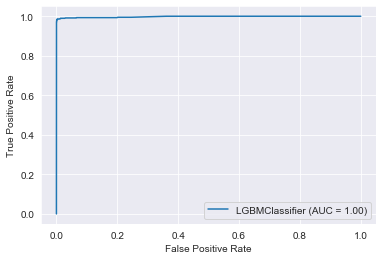

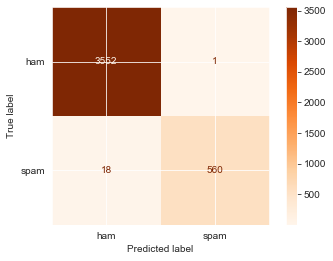

In [46]:
%%time

#### Train dataset metrics
Spam_Utils.custom_classification_metrics(estimator_list[5],x_train,y_train,y_train_preds[5],labels,'Train')
    

Test  dataset has an accuracy of  98.0
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1208
        spam       0.97      0.90      0.93       169

    accuracy                           0.98      1377
   macro avg       0.98      0.95      0.96      1377
weighted avg       0.98      0.98      0.98      1377

The ROC AUC Score on  Test  dataset :  0.99
Wall time: 298 ms


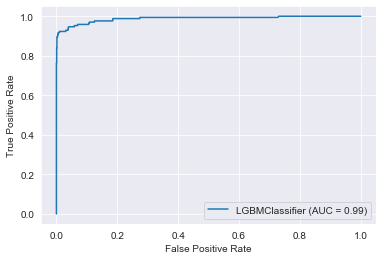

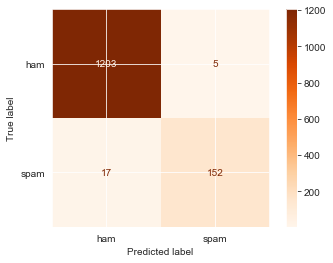

In [47]:
%%time

#### Test dataset metrics
Spam_Utils.custom_classification_metrics(estimator_list[5],x_test,y_test,y_test_preds[5],labels,'Test')
    